In [1]:
import numpy as np
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras.models import Model, model_from_json
from tensorflow.keras import Sequential
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Lambda, Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.models import Model
    
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from matplotlib import gridspec
from matplotlib import patches

import energyflow as ef
from energyflow.archs import PFN, EFN
from energyflow.utils import to_categorical

plt.rcParams["font.family"] = "serif"

/global/home/users/bpnachman/anaconda3/envs/tf2/lib/python3.8/site-packages/energyflow/emd.py:915: UserWarning: emd module requires 'wasserstein' or 'pot', both of which are unavailable
  warnings.warn(message)


In [2]:
retrain = False

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')

In [4]:
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)]) #in MB

## Gaussian example

In [5]:
epsilon = 0.1
N = 100000

if (retrain):
    
    myoneD_signal = np.random.normal(epsilon,1,N)
    myoneD_background = np.random.normal(-epsilon,1,N)
    
    X_1D = np.concatenate([myoneD_signal,myoneD_background])
    Y_1D = np.concatenate([np.ones(len(myoneD_signal)),np.zeros(len(myoneD_background))])

    n = 10
    if (N % n != 0):
        print("That is not a valid choice!")

    X_nD = np.reshape(X_1D,[int(len(X_1D)/n),n])
    Y_nD = np.concatenate([np.ones(int(len(myoneD_signal)/n)),np.zeros(int(len(myoneD_background)/n))])

    X_1D_train, X_1D_val, Y_1D_train, Y_1D_val = train_test_split(X_1D, Y_1D, test_size=0.5)
    X_nD_train, X_nD_val, Y_nD_train, Y_nD_val = train_test_split(X_nD, Y_nD, test_size=0.5)

In [6]:
#Save everything
if (retrain):
    np.save("ensemblelearning/Y_1D_val",Y_1D_val)
    np.save("ensemblelearning/X_1D_val",X_1D_val)
    np.save("ensemblelearning/Y_1D_train",Y_1D_train)
    np.save("ensemblelearning/X_1D_train",X_1D_train)

    np.save("ensemblelearning/Y_nD_val",Y_nD_val)
    np.save("ensemblelearning/X_nD_val",X_nD_val)
    np.save("ensemblelearning/Y_nD_train",Y_nD_train)
    np.save("ensemblelearning/X_nD_train",X_nD_train)

    model_json = model1D.to_json()
    with open("ensemblelearning/model1D.json", "w") as json_file:
        json_file.write(model_json)
    model1D.save_weights("ensemblelearning/model1D.h5")

    model_json = modelnD.to_json()
    with open("ensemblelearning/modelnD.json", "w") as json_file:
        json_file.write(model_json)
    modelnD.save_weights("ensemblelearning/modelnD.h5")
else:
    #Load everything
    Y_1D_val = np.load("ensemblelearning/Y_1D_val.npy")
    X_1D_val = np.load("ensemblelearning/X_1D_val.npy")
    Y_1D_train = np.load("ensemblelearning/Y_1D_train.npy")
    X_1D_train = np.load("ensemblelearning/X_1D_train.npy")

    Y_nD_val = np.load("ensemblelearning/Y_nD_val.npy")
    X_nD_val = np.load("ensemblelearning/X_nD_val.npy")
    Y_nD_train = np.load("ensemblelearning/Y_nD_train.npy")
    X_nD_train = np.load("ensemblelearning/X_nD_train.npy")

    json_file = open('ensemblelearning/model1D.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model1D = model_from_json(loaded_model_json)
    model1D.load_weights("ensemblelearning/model1D.h5")

    json_file = open('ensemblelearning/modelnD.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    modelnD = model_from_json(loaded_model_json)
    modelnD.load_weights("ensemblelearning/modelnD.h5")

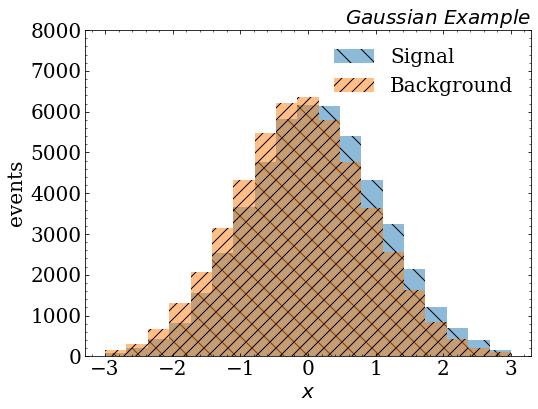

In [7]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

plt.hist(X_1D_val[Y_1D_val==1],bins=np.linspace(-3,3,20),alpha=0.5,label="Signal",hatch='\\')
plt.hist(X_1D_val[Y_1D_val==0],bins=np.linspace(-3,3,20),alpha=0.5,label="Background",hatch='//')
plt.ylim([0,8000])
plt.xlabel("$x$",fontsize=20)
plt.ylabel("events",fontsize=20)
plt.legend(frameon=False,fontsize=20)
plt.title(r"$Gaussian$ $Example$",loc="right",fontsize=20)
plt.savefig("ensembleLearnPlots/Gaussian_Xhist.pdf",bbox_inches='tight')

In [8]:
if (retrain):
    model1D = Sequential()
    model1D.add(Dense(128, activation='relu',input_shape =(1,))) 
    model1D.add(Dense(128, activation='relu'))
    model1D.add(Dense(1, activation='sigmoid'))
    model1D.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    hist_model1D= model1D.fit(X_1D_train, Y_1D_train, epochs=10, batch_size=int(0.1*len(X_1D_train)),validation_data=(X_1D_val, Y_1D_val))

In [9]:
if (retrain):
    modelnD = Sequential()
    modelnD.add(Dense(128, activation='relu',input_shape =(n,))) 
    modelnD.add(Dense(128, activation='relu'))
    modelnD.add(Dense(1, activation='sigmoid'))
    modelnD.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    hist_modelnD= modelnD.fit(X_nD_train, Y_nD_train, epochs=2, batch_size=128,validation_data=(X_nD_val, Y_nD_val))

In [10]:
#Save everything
if (retrain):
    np.save("ensemblelearning/Y_1D_val",Y_1D_val)
    np.save("ensemblelearning/X_1D_val",X_1D_val)
    np.save("ensemblelearning/Y_1D_train",Y_1D_train)
    np.save("ensemblelearning/X_1D_train",X_1D_train)

    np.save("ensemblelearning/Y_nD_val",Y_nD_val)
    np.save("ensemblelearning/X_nD_val",X_nD_val)
    np.save("ensemblelearning/Y_nD_train",Y_nD_train)
    np.save("ensemblelearning/X_nD_train",X_nD_train)

    model_json = model1D.to_json()
    with open("ensemblelearning/model1D.json", "w") as json_file:
        json_file.write(model_json)
    model1D.save_weights("ensemblelearning/model1D.h5")

    model_json = modelnD.to_json()
    with open("ensemblelearning/modelnD.json", "w") as json_file:
        json_file.write(model_json)
    modelnD.save_weights("ensemblelearning/modelnD.h5")
else:
    #Load everything
    Y_1D_val = np.load("ensemblelearning/Y_1D_val.npy")
    X_1D_val = np.load("ensemblelearning/X_1D_val.npy")
    Y_1D_train = np.load("ensemblelearning/Y_1D_train.npy")
    X_1D_train = np.load("ensemblelearning/X_1D_train.npy")

    Y_nD_val = np.load("ensemblelearning/Y_nD_val.npy")
    X_nD_val = np.load("ensemblelearning/X_nD_val.npy")
    Y_nD_train = np.load("ensemblelearning/Y_nD_train.npy")
    X_nD_train = np.load("ensemblelearning/X_nD_train.npy")

    json_file = open('ensemblelearning/model1D.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model1D = model_from_json(loaded_model_json)
    model1D.load_weights("ensemblelearning/model1D.h5")

    json_file = open('ensemblelearning/modelnD.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    modelnD = model_from_json(loaded_model_json)
    modelnD.load_weights("ensemblelearning/modelnD.h5")

In [11]:
n = 10

scores_1D = model1D.predict(X_1D_val,batch_size=int(0.1*len(X_1D_val)))
scores_nD = modelnD.predict(X_nD_val,batch_size=int(0.1*len(X_1D_val)))

scores_1D_fromnD = model1D.predict(np.reshape(X_nD_val,[n*len(X_nD_val)]),batch_size=int(0.1*len(X_1D_val)))
scores_1D_fromnD = np.reshape(scores_1D_fromnD,[int(len(scores_1D_fromnD)/n),n])
scaled_up = np.array([np.prod(scores_1D_fromnD[i,:] / (1.-scores_1D_fromnD[i,:])) for i in range(len(scores_1D_fromnD))])

fpr_1D, tpr_1D, _ = roc_curve(Y_1D_val, scores_1D)
fpr_nD, tpr_nD, _ = roc_curve(Y_nD_val, scores_nD)
fpr_nD_from1D, tpr_nD_from1D, _ = roc_curve(Y_nD_val, scaled_up)

fpr_ana, tpr_ana, _ = roc_curve(Y_1D_val, np.exp(-(X_1D_val-epsilon)**2/2+(X_1D_val+epsilon)**2/2))

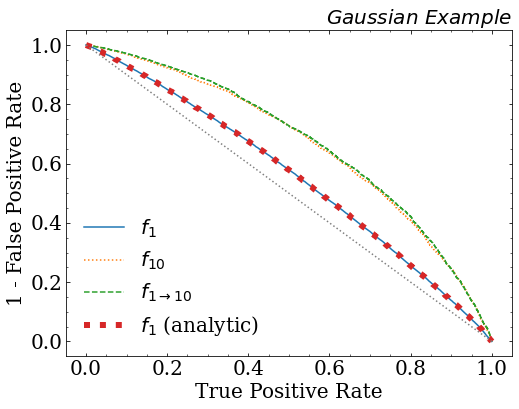

In [12]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

plt.plot(tpr_1D,1-fpr_1D,label="$f_{1}$")
plt.plot(tpr_nD,1-fpr_nD,label="$f_{10}$",ls=":")
plt.plot(tpr_nD_from1D,1-fpr_nD_from1D,label=r"$f_{1\rightarrow 10}$",ls="--")
plt.plot(tpr_ana,1-fpr_ana,label="$f_{1}$ (analytic)",ls=":",lw=6)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=20)
plt.ylabel("1 - False Positive Rate",fontsize=20)
plt.legend(frameon=False)
plt.title(r"$Gaussian$ $Example$",loc="right",fontsize=20)

plt.legend(frameon=False,fontsize=20)
plt.savefig("ensembleLearnPlots/Gaussian_ROC.pdf",bbox_inches='tight')

In [13]:
X_nD_train_pfn = np.reshape(X_nD_train,[len(X_nD_train),n,1])
X_nD_val_pfn = np.reshape(X_nD_val,[len(X_nD_val),n,1])

In [14]:
Phi_sizes_Gaussian, F_sizes_Gaussian = (100, 100, 128, 1), []
pfn_Gaussian = PFN(input_dim=X_nD_val_pfn.shape[-1], Phi_sizes=Phi_sizes_Gaussian, F_sizes=F_sizes_Gaussian, F_acts='linear', output_dim=1, output_act='linear', Phi_acts=['relu','relu','relu','linear'])

pfn_Gaussian.model.layers.pop()
pfn_Gaussian.model.layers.pop()
for layer in pfn_Gaussian.model.layers:
    print(layer)
pfn_Gaussian.model.compile(loss=lambda y_true, y_pred: myloss_many(y_true, y_pred), optimizer='adam', metrics=['accuracy'])

if (retrain):
    #Train 1 from N
    def myloss_many(y_true, y_pred):
        return binary_crossentropy(y_true,K.exp(y_pred)/(1.+K.exp(y_pred)))

    historyf_Gaussian = pfn_Gaussian.fit(X_nD_train_pfn, Y_nD_train,
              epochs=20,
              batch_size=128,
              validation_data=(X_nD_val_pfn, Y_nD_val),
              verbose=1)
    
    pfn_Gaussian.save_weights("ensemblelearning/modelGaussian_PFN.h5")
else:
    pfn_Gaussian.load_weights("ensemblelearning/modelGaussian_PFN.h5")
    
myPhi_predsN_Gaussian = pfn_Gaussian.predict(X_nD_val_pfn,batch_size=int(0.1*len(X_nD_train_pfn)))
fpr_PhiN_Gaussian, tpr_PhiN_Gaussian, _ = roc_curve(Y_nD_val, myPhi_predsN_Gaussian)

myPhi_Gaussian = Model(pfn_Gaussian.model.input,pfn_Gaussian.model.layers[-4].output)
myPhi_preds_Gaussian = myPhi_Gaussian.predict(X_nD_val_pfn,batch_size=int(0.1*len(X_nD_train_pfn)))
preds_Phi_Gaussian = np.reshape(myPhi_preds_Gaussian,[n*len(myPhi_preds_Gaussian)])
Y_Phi_Gaussian = [Y_nD_val[i]*np.ones(n) for i in range(len(Y_nD_val))]
Y_Phi_Gaussian = np.reshape(Y_Phi_Gaussian,[n*len(Y_Phi_Gaussian)])
fpr_Phi_Gaussian, tpr_Phi_Gaussian, _ = roc_curve(Y_Phi_Gaussian, preds_Phi_Gaussian)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    200         input[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation[0][0]                 
______________________________________________________________________________________________

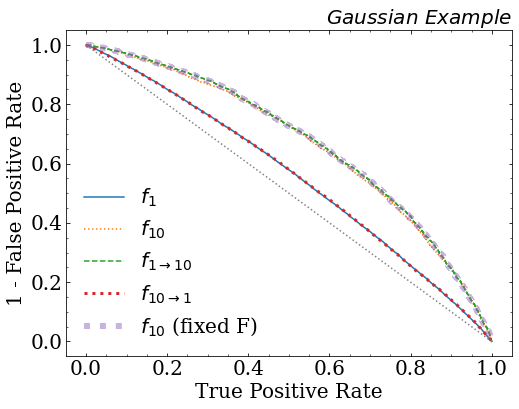

In [15]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

plt.plot(tpr_1D,1-fpr_1D,label="$f_{1}$")
plt.plot(tpr_nD,1-fpr_nD,label="$f_{10}$",ls=":")
plt.plot(tpr_nD_from1D,1-fpr_nD_from1D,label=r"$f_{1\rightarrow 10}$",ls="--")
plt.plot(tpr_Phi_Gaussian,1-fpr_Phi_Gaussian,label=r"$f_{10\rightarrow 1}$",ls=":",lw=3)
plt.plot(tpr_PhiN_Gaussian,1-fpr_PhiN_Gaussian,label="$f_{10}$ (fixed F)",ls=":",lw=6,alpha=0.5)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=20)
plt.ylabel("1 - False Positive Rate",fontsize=20)
plt.legend(frameon=False)
plt.title(r"$Gaussian$ $Example$",loc="right",fontsize=20)

plt.legend(frameon=False,fontsize=20)
plt.savefig("ensembleLearnPlots/Gaussian_ROC_both.pdf",bbox_inches='tight')

In [16]:
#Now, let's do regression.

In [17]:
#First, direct regression.

#Save everything
if (retrain):
    thetas_standardregression = np.random.uniform(-0.5,0.5,10000)
    thetas_standardregression = np.array([thetas_standardregression[i]*np.ones(100) for i in range(10000)])
    xs_standardregression = np.random.normal(thetas_standardregression,1)

    X_MSE_train, X_MSE_val, Y_MSE_train, Y_MSE_val = train_test_split(xs_standardregression,thetas_standardregression, test_size=0.5)
    
    np.save("ensemblelearning/thetas_standardregression",thetas_standardregression)
    np.save("ensemblelearning/xs_standardregression",xs_standardregression)
    np.save("ensemblelearning/X_MSE_train",X_MSE_train)
    np.save("ensemblelearning/X_MSE_val",X_MSE_val)
    np.save("ensemblelearning/Y_MSE_train",Y_MSE_train)
    np.save("ensemblelearning/Y_MSE_val",Y_MSE_val)
else:
    thetas_standardregression = np.load("ensemblelearning/thetas_standardregression.npy")
    xs_standardregression = np.load("ensemblelearning/xs_standardregression.npy")
    X_MSE_train = np.load("ensemblelearning/X_MSE_train.npy")
    X_MSE_val = np.load("ensemblelearning/X_MSE_val.npy")
    Y_MSE_train = np.load("ensemblelearning/Y_MSE_train.npy")
    Y_MSE_val = np.load("ensemblelearning/Y_MSE_val.npy")

In [18]:
if (retrain):
    model_MSE = Sequential()
    model_MSE.add(Dense(64, activation='relu',input_shape =(100,))) 
    model_MSE.add(Dense(128, activation='relu'))
    model_MSE.add(Dense(64, activation='relu'))
    model_MSE.add(Dense(1, activation='linear')) 
    model_MSE.compile(loss="mse", optimizer='adam', metrics=['accuracy'])
    hist_MSE = model_MSE.fit(X_MSE_train, Y_MSE_train, epochs=20, batch_size=int(0.1*len(X_MSE_train)),validation_data=(X_MSE_val, Y_MSE_val))
    
    model_json = model_MSE.to_json()
    with open("ensemblelearning/model_MSE.json", "w") as json_file:
        json_file.write(model_json)
    model_MSE.save_weights("ensemblelearning/model_MSE.h5")
else:
    json_file = open('ensemblelearning/model_MSE.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model_MSE = model_from_json(loaded_model_json)
    model_MSE.load_weights("ensemblelearning/model_MSE.h5")

In [19]:
if (retrain):
    xs_standardregression_0 = np.random.normal(0.,1,100*10000)
    np.save("ensemblelearning/xs_standardregression_0",xs_standardregression_0)
else:
    xs_standardregression_0 = np.load("ensemblelearning/xs_standardregression_0.npy")
xs_standardregression_classifier = xs_standardregression.flatten()
thetas_standardregression_classifier = thetas_standardregression.flatten()
xvals_nonstandardregression_sig = np.c_[xs_standardregression_classifier,thetas_standardregression_classifier]
xvals_nonstandardregression_bac = np.c_[xs_standardregression_0,thetas_standardregression_classifier]
xvals_nonstandardregression = np.concatenate([xvals_nonstandardregression_sig,xvals_nonstandardregression_bac])
yvals_nonstadnardregression = np.concatenate([np.ones(100*10000),np.zeros(100*10000)])

if (retrain):
    X_MSE2_train, X_MSE2_val, Y_MSE2_train, Y_MSE2_val = train_test_split(xvals_nonstandardregression, yvals_nonstadnardregression,test_size=0.5)
    np.save("ensemblelearning/X_MSE2_train",X_MSE2_train)
    np.save("ensemblelearning/Y_MSE2_train",Y_MSE2_train)
    np.save("ensemblelearning/X_MSE2_val",X_MSE2_val)
    np.save("ensemblelearning/Y_MSE2_val",Y_MSE2_val)
else:
    X_MSE2_train = np.load("ensemblelearning/X_MSE2_train.npy")
    Y_MSE2_train = np.load("ensemblelearning/Y_MSE2_train.npy")
    X_MSE2_val = np.load("ensemblelearning/X_MSE2_val.npy")
    Y_MSE2_val = np.load("ensemblelearning/Y_MSE2_val.npy")

In [20]:
if (retrain):
    model_MSE2 = Sequential()
    model_MSE2.add(Dense(64, activation='relu',input_shape =(2,))) 
    model_MSE2.add(Dense(128, activation='relu'))
    model_MSE2.add(Dense(64, activation='relu'))
    model_MSE2.add(Dense(1, activation='sigmoid')) 
    model_MSE2.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
    hist_MSE2 = model_MSE2.fit(X_MSE2_train, Y_MSE2_train, epochs=20, batch_size=int(0.1*len(X_MSE2_train)),validation_data=(X_MSE2_val, Y_MSE2_val))
    
    model_json = model_MSE2.to_json()
    with open("ensemblelearning/model_MSE2.json", "w") as json_file:
        json_file.write(model_json)
    model_MSE2.save_weights("ensemblelearning/model_MSE2.h5")
else:
    json_file = open('ensemblelearning/model_MSE2.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model_MSE2 = model_from_json(loaded_model_json)
    model_MSE2.load_weights("ensemblelearning/model_MSE2.h5")

In [29]:
vals_standard = []
vals_new = []
vals_MLE = []
valse_standard = []
valse_new = []
valse_MLE = []

if (retrain):
    for th_true in np.linspace(-0.5,0.5,10):
        for i in range(10):
            testset = np.reshape(np.random.normal(th_true,1,100),[1,100])
            np.save("ensemblelearning/"+str(th_true)+"_"+str(i),testset)

for th_true in np.linspace(-0.5,0.5,10):
    print("on val=",th_true)
    
    vals_standard_hold = []
    vals_new_hold = []
    vals_MLE_hold = []
    
    for i in range(10):
        #testset = np.reshape(np.random.normal(th_true,1,100),[1,100])
        testset = np.load("ensemblelearning/"+str(th_true)+"_"+str(i)+".npy")
        vals_standard_hold+=[model_MSE.predict(testset)[0][0]]

        num = 0.
        den = 0.
        holdvals = []
        thvals = np.linspace(-0.5,0.5,20)
        for theta_hold in thvals:
            test_input = np.c_[testset[0],theta_hold*np.ones(100)]
            preds_MSE2 = model_MSE2.predict(test_input,batch_size=int(0.1*len(test_input)))
            num += theta_hold*np.product(preds_MSE2[:,0]/(1.-preds_MSE2[:,0]))
            den += np.product(preds_MSE2[:,0]/(1.-preds_MSE2[:,0]))
            holdvals+=[np.product(preds_MSE2[:,0]/(1.-preds_MSE2[:,0]))]
            pass
        vals_MLE_hold+=[thvals[np.argmax(holdvals)]]
        vals_new_hold+=[num/den]
        pass
    vals_standard+=[np.mean(vals_standard_hold)]
    vals_new+=[np.mean(vals_new_hold)]
    vals_MLE+=[np.mean(vals_MLE_hold)]
    valse_standard+=[np.std(vals_standard_hold)/10**0.5]
    valse_new+=[np.std(vals_new_hold)/10**0.5]
    valse_MLE+=[np.std(vals_MLE_hold)/10**0.5]

vals_standard = np.array(vals_standard)
vals_new = np.array(vals_new)
vals_MLE = np.array(vals_MLE)
valse_standard = np.array(valse_standard)
valse_new = np.array(valse_new)
valse_MLE = np.array(valse_MLE)

on val= -0.5
on val= -0.3888888888888889
on val= -0.2777777777777778
on val= -0.16666666666666669
on val= -0.05555555555555558
on val= 0.05555555555555558
on val= 0.16666666666666663
on val= 0.2777777777777777
on val= 0.38888888888888884
on val= 0.5


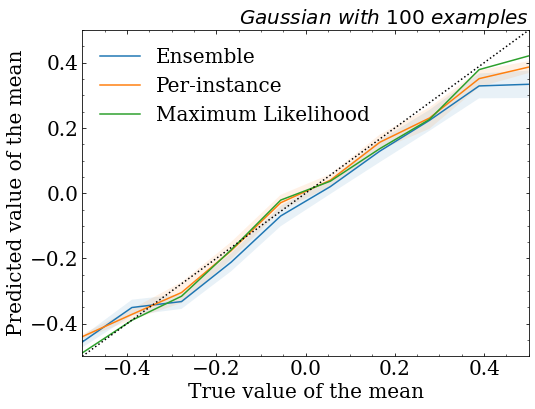

In [30]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

plt.plot(np.linspace(-0.5,0.5,10),vals_standard,label="Ensemble")
plt.plot(np.linspace(-0.5,0.5,10),vals_new,label="Per-instance")
plt.plot(np.linspace(-0.5,0.5,10),vals_MLE,label="Maximum Likelihood")
plt.fill_between(np.linspace(-0.5,0.5,10),vals_standard-valse_standard,vals_standard+valse_standard,alpha=0.1)
plt.fill_between(np.linspace(-0.5,0.5,10),vals_new-valse_new,vals_new+valse_new,alpha=0.1)
plt.plot([-0.5,0.5],[-0.5,0.5],color="black",ls=":")
plt.xlim([-0.5,0.5])
plt.ylim([-0.5,0.5])
plt.xlabel("True value of the mean",fontsize=20)
plt.ylabel("Predicted value of the mean",fontsize=20)
plt.title("$Gaussian$ $with$ $100$ $examples$",loc="right",fontsize=20)
plt.legend(frameon=False,fontsize=20)
plt.savefig("ensembleLearnPlots/Gaussian_DirectRegression.pdf",bbox_inches='tight')

In [31]:
#Finally, let's do mutual information.

myvals = []
true_vals = []

for muval in np.linspace(0,2,10):
    
    print("on muval = ",muval)

    if (retrain):
        signal = np.random.normal(muval,1,100000)
        background = np.random.normal(-muval,1,100000)
        np.save("ensemblelearning/MI_signal"+str(muval),signal)
        np.save("ensemblelearning/MI_background"+str(muval),background)
    else:
        signal = np.load("ensemblelearning/MI_signal"+str(muval)+".npy")
        background = np.load("ensemblelearning/MI_background"+str(muval)+".npy")
        pass
  
    X = np.concatenate([signal,background])
    Y = np.concatenate([np.ones(len(signal)),np.zeros(len(background))])
    Y_mix = np.concatenate([np.ones(len(signal)),np.zeros(len(background))])
    joint = np.c_[X,Y]
    np.random.shuffle(Y_mix)
    marginal = np.c_[X,Y_mix]
    
    if (retrain):
        X_train, X_val, Y_train, Y_val = train_test_split(np.concatenate([joint,marginal]),np.concatenate([np.ones(len(joint)),np.zeros(len(marginal))]),test_size=0.5)
        np.save("ensemblelearning/MI_X_train"+str(muval),X_train)
        np.save("ensemblelearning/MI_X_val"+str(muval),X_val)
        np.save("ensemblelearning/MI_Y_train"+str(muval),Y_train)
        np.save("ensemblelearning/MI_Y_val"+str(muval),Y_val)
    else:
        X_train = np.load("ensemblelearning/MI_X_train"+str(muval)+".npy")
        X_val = np.load("ensemblelearning/MI_X_val"+str(muval)+".npy")
        Y_train = np.load("ensemblelearning/MI_Y_train"+str(muval)+".npy")
        Y_val = np.load("ensemblelearning/MI_Y_val"+str(muval)+".npy")
    
    if (retrain):
        model = Sequential()
        model.add(Dense(64, activation='relu',input_shape =(2,))) 
        model.add(Dense(64, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        hist = model.fit(X_train, Y_train, epochs=20, batch_size=int(0.1*len(X_train)),validation_data=(X_val, Y_val))

        model_json = model.to_json()
        with open("ensemblelearning/MI_model"+str(muval)+".json", "w") as json_file:
            json_file.write(model_json)
        model.save_weights("ensemblelearning/MI_model"+str(muval)+".h5")
    else:
        json_file = open("ensemblelearning/MI_model"+str(muval)+".json", 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        model = model_from_json(loaded_model_json)
        model.load_weights("ensemblelearning/MI_model"+str(muval)+".h5")
        
    preds = model.predict(joint,batch_size=int(0.1*len(joint)))

    myvals += [np.mean(np.log(preds/(1.-preds)))]

    num = np.exp(-(joint[:,0]-muval*(2*joint[:,1]-1))**2/2.)/np.sqrt(2.*np.pi)
    den = 0.5*(np.exp(-(joint[:,0]-muval)**2/2.)/np.sqrt(2.*np.pi)+np.exp(-(joint[:,0]+muval)**2/2.)/np.sqrt(2.*np.pi))
    true_vals += [np.mean(np.log(num/den))] #can compute analytically, but the integrals are a little annoying

on muval =  0.0
on muval =  0.2222222222222222
on muval =  0.4444444444444444
on muval =  0.6666666666666666
on muval =  0.8888888888888888
on muval =  1.1111111111111112
on muval =  1.3333333333333333
on muval =  1.5555555555555554
on muval =  1.7777777777777777
on muval =  2.0


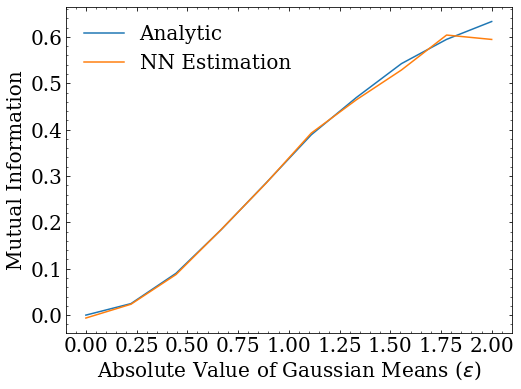

In [32]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

plt.plot(np.linspace(0,2,10),true_vals,label="Analytic")
plt.plot(np.linspace(0,2,10),myvals,label="NN Estimation")
plt.xlabel("Absolute Value of Gaussian Means ($\epsilon$)",fontsize=20)
plt.ylabel("Mutual Information",fontsize=20)
plt.legend(frameon=False,fontsize=20)
plt.savefig("ensembleLearnPlots/MutualInformation.pdf",bbox_inches='tight')

## BSM example

In [33]:
features_sig=pd.read_hdf("/global/home/users/bpnachman/data/bpnachman/Anomalies/LHCO/events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5")
features_bg=pd.read_hdf("/global/home/users/bpnachman/data/bpnachman/Anomalies/LHCO/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5")

In [34]:
def load_data(input_frame):
    dataset = input_frame[["mj1","tau1j1","tau2j1","mj2","tau1j2","tau2j2"]]
    dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
    dataset["mjTwo"] = dataset[["mj1", "mj2"]].max(axis=1)
    dataset["mjOne"] = dataset[["mj1", "mj2"]].min(axis=1)
    dataset["mjDelta"] = dataset["mjTwo"] - dataset["mjOne"]
    dataset["tau1jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau1jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau21jOne"] = dataset["tau2jOne"]/dataset["tau1jOne"]
    dataset["tau21jTwo"] = dataset["tau2jTwo"]/dataset["tau1jTwo"]
    dataset["mjTwo"] = dataset["mjTwo"]/1000.
    dataset["mjOne"] = dataset["mjOne"]/1000.
    dataset["mjDelta"] = dataset["mjDelta"]/1000.
    dataset = dataset.fillna(0)
    dataset = dataset[["mjj","mjOne","mjDelta","tau21jOne","tau21jTwo"]]
    return dataset.to_numpy()

In [35]:
dataset_bg=load_data(features_bg)
dataset_bg=np.hstack((dataset_bg,np.zeros((len(dataset_bg),1))))

dataset_sig=load_data(features_sig)
dataset_sig=np.hstack((dataset_sig,np.ones((len(dataset_sig),1))))

<ipython-input-34-57dd470396b9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
<ipython-input-34-57dd470396b9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

In [36]:
SR_low = 3.3
SR_high = 3.7

n_phys = 3

X_sig_SR = dataset_sig[(dataset_sig[:,0] > SR_low)*(dataset_sig[:,0] < SR_high)][:,1:5]
X_bg_SR = dataset_bg[(dataset_bg[:,0] > SR_low)*(dataset_bg[:,0] < SR_high)][:,1:5]

X_sig_SR = X_sig_SR[0:len(X_sig_SR) - len(X_sig_SR) % n_phys]
X_bg_SR = X_bg_SR[0:len(X_bg_SR) - len(X_bg_SR) % n_phys]

X_1D_phys = np.concatenate([X_sig_SR,X_bg_SR])
Y_1D_phys = np.concatenate([np.ones(len(X_sig_SR)),np.zeros(len(X_bg_SR))])

X_nD_phys = np.reshape(X_1D_phys,[int(len(X_1D_phys)/n_phys),4*n_phys])
Y_nD_phys = np.concatenate([np.ones(int(len(X_sig_SR)/n_phys)),np.zeros(int(len(X_bg_SR)/n_phys))])

#Try standardizing?
scaler = preprocessing.StandardScaler().fit(X_nD_phys)
X_nD_phys = scaler.transform(X_nD_phys)

scaler1D = preprocessing.StandardScaler().fit(X_1D_phys)
X_1D_phys = scaler1D.transform(X_1D_phys)

if (retrain):
    X_1D_train_phys, X_1D_val_phys, Y_1D_train_phys, Y_1D_val_phys = train_test_split(X_1D_phys, Y_1D_phys, test_size=0.5)
    X_nD_train_phys, X_nD_val_phys, Y_nD_train_phys, Y_nD_val_phys = train_test_split(X_nD_phys, Y_nD_phys, test_size=0.5)

    np.save("ensemblelearning/Y_1D_val_phys",Y_1D_val_phys)
    np.save("ensemblelearning/X_1D_val_phys",X_1D_val_phys)
    np.save("ensemblelearning/Y_1D_train_phys",Y_1D_train_phys)
    np.save("ensemblelearning/X_1D_train_phys",X_1D_train_phys)

    np.save("ensemblelearning/Y_nD_val_phys",Y_nD_val_phys)
    np.save("ensemblelearning/X_nD_val_phys",X_nD_val_phys)
    np.save("ensemblelearning/Y_nD_train_phys",Y_nD_train_phys)
    np.save("ensemblelearning/X_nD_train_phys",X_nD_train_phys)
else:
    Y_1D_val_phys = np.load("ensemblelearning/Y_1D_val_phys.npy")
    X_1D_val_phys = np.load("ensemblelearning/X_1D_val_phys.npy")
    Y_1D_train_phys = np.load("ensemblelearning/Y_1D_train_phys.npy")
    X_1D_train_phys = np.load("ensemblelearning/X_1D_train_phys.npy")

    Y_nD_val_phys = np.load("ensemblelearning/Y_nD_val_phys.npy")
    X_nD_val_phys = np.load("ensemblelearning/X_nD_val_phys.npy")
    Y_nD_train_phys = np.load("ensemblelearning/Y_nD_train_phys.npy")
    X_nD_train_phys = np.load("ensemblelearning/X_nD_train_phys.npy")
    pass

#Sort the n-dimensional case based on mJ1
X_nD_train_sort_phys = np.array([np.reshape(sorted(np.reshape(X_nD_train_phys[i],[n_phys,4]), key=lambda x: x[0]),[n_phys*4]) for i in range(len(X_nD_train_phys))])
X_nD_val_sort_phys = np.array([np.reshape(sorted(np.reshape(X_nD_val_phys[i],[n_phys,4]), key=lambda x: x[0]),[n_phys*4]) for i in range(len(X_nD_val_phys))])

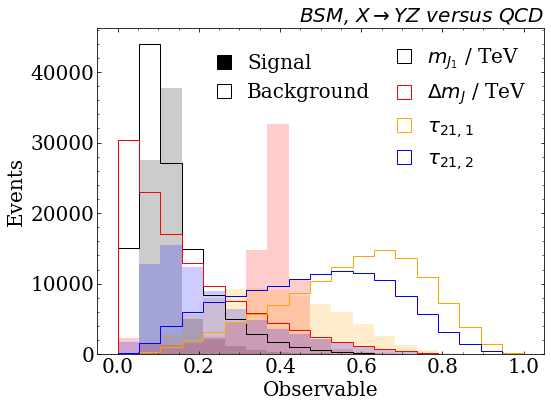

In [37]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

plt.hist(X_sig_SR[:,0],bins=np.linspace(0,1,20),alpha=0.2,color="black")
plt.hist(X_sig_SR[:,1],bins=np.linspace(0,1,20),alpha=0.2,color="red")
plt.hist(X_sig_SR[:,2],bins=np.linspace(0,1,20),alpha=0.2,color="orange")
plt.hist(X_sig_SR[:,3],bins=np.linspace(0,1,20),alpha=0.2,color="blue")

plt.hist(X_bg_SR[:,0],bins=np.linspace(0,1,20),color="black",histtype='step',label=r"$m_{J_1}$ / TeV")
plt.hist(X_bg_SR[:,1],bins=np.linspace(0,1,20),color="red",histtype='step',label=r"$\Delta m_J$ / TeV")
plt.hist(X_bg_SR[:,2],bins=np.linspace(0,1,20),color="orange",histtype='step',label=r"$\tau_{21,1}$")
plt.hist(X_bg_SR[:,3],bins=np.linspace(0,1,20),color="blue",histtype='step',label=r"$\tau_{21,2}$")

plt.xlabel("Observable",fontsize=20)
plt.ylabel("Events",fontsize=20)
leg = plt.legend(frameon=False,fontsize=20, handlelength=0.7)

x = patches.Patch(color='black', label='Signal',fill=True)
x2 = patches.Patch(color='black', label='Background',fill=False)

leg2 = plt.legend(handles=[x,x2],loc=(0.25, 0.75),fontsize=20,frameon=False, handlelength=0.7)
plt.gca().add_artist(leg)
plt.title(r"$BSM$, $X\rightarrow YZ$ $versus$ $QCD$",loc="right",fontsize=20)

plt.savefig("ensembleLearnPlots/BSM_Hist.pdf",bbox_inches='tight')

In [38]:
if (retrain):
    model_1D_phys = Sequential()
    model_1D_phys.add(Dense(64, input_dim=4, activation='relu')) 
    model_1D_phys.add(Dense(64, activation='relu'))
    model_1D_phys.add(Dense(64, activation='relu'))
    model_1D_phys.add(Dense(1, activation='sigmoid'))
    model_1D_phys.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_1D_phys.fit(X_1D_train_phys,Y_1D_train_phys, epochs=100, batch_size=int(0.1*len(X_1D_train_phys)),validation_data=(X_1D_val_phys,Y_1D_val_phys))
    
    model_json = model_1D_phys.to_json()
    with open("ensemblelearning/model_1D_phys.json", "w") as json_file:
        json_file.write(model_json)
    model_1D_phys.save_weights("ensemblelearning/model_1D_phys.h5")
else:
    json_file = open('ensemblelearning/model_1D_phys.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model_1D_phys = model_from_json(loaded_model_json)
    model_1D_phys.load_weights("ensemblelearning/model_1D_phys.h5")

In [39]:
if (retrain):
    model_nD_phys = Sequential()
    model_nD_phys.add(Dense(64, input_dim=4*n_phys, activation='relu')) 
    model_nD_phys.add(Dense(64, activation='relu'))
    model_nD_phys.add(Dense(64, activation='relu'))
    model_nD_phys.add(Dense(1, activation='sigmoid'))
    model_nD_phys.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_nD_phys.fit(X_nD_train_phys,Y_nD_train_phys, epochs=100, batch_size=int(0.1*len(X_nD_train_phys)),validation_data=(X_nD_val_phys,Y_nD_val_phys))
    
    model_json = model_nD_phys.to_json()
    with open("ensemblelearning/model_nD_phys.json", "w") as json_file:
        json_file.write(model_json)
    model_nD_phys.save_weights("ensemblelearning/model_nD_phys.h5")
else:
    json_file = open('ensemblelearning/model_nD_phys.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model_nD_phys = model_from_json(loaded_model_json)
    model_nD_phys.load_weights("ensemblelearning/model_nD_phys.h5")

In [40]:
if (retrain):
    model_nD_sort_phys = Sequential()
    model_nD_sort_phys.add(Dense(64, input_dim=4*n_phys, activation='relu')) 
    model_nD_sort_phys.add(Dense(64, activation='relu'))
    model_nD_sort_phys.add(Dense(64, activation='relu'))
    model_nD_sort_phys.add(Dense(1, activation='sigmoid'))
    model_nD_sort_phys.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_nD_sort_phys.fit(X_nD_train_sort_phys,Y_nD_train_phys, epochs=100, batch_size=int(0.1*len(X_nD_train_sort_phys)),validation_data=(X_nD_val_sort_phys,Y_nD_val_phys))
    
    model_json = model_nD_sort_phys.to_json()
    with open("ensemblelearning/model_nD_sort_phys.json", "w") as json_file:
        json_file.write(model_json)
    model_nD_sort_phys.save_weights("ensemblelearning/model_nD_sort_phys.h5")
else:
    json_file = open('ensemblelearning/model_nD_sort_phys.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model_nD_sort_phys = model_from_json(loaded_model_json)
    model_nD_sort_phys.load_weights("ensemblelearning/model_nD_sort_phys.h5")

In [41]:
scores_1D_phys = model_1D_phys.predict(X_1D_val_phys,batch_size=int(0.1*len(X_1D_train_phys)))
scores_nD_phys = model_nD_phys.predict(X_nD_val_phys,batch_size=int(0.1*len(X_nD_train_phys)))
scores_nD_sort_phys = model_nD_sort_phys.predict(X_nD_val_sort_phys,batch_size=int(0.1*len(X_nD_train_sort_phys)))

In [42]:
#scores_1D_fromnD_phys = model_1D_phys.predict(np.reshape(X_nD_val_phys,[n_phys*len(X_nD_val_phys),4]),batch_size=int(0.1*len(X_nD_train_phys)))
scores_1D_fromnD_phys = model_1D_phys.predict(scaler1D.transform(np.reshape(scaler.inverse_transform(X_nD_val_phys),[n_phys*len(X_nD_val_phys),4])),batch_size=int(0.1*len(X_nD_train_phys)))

In [43]:
scores_1D_fromnD_phys = np.reshape(scores_1D_fromnD_phys,[int(len(scores_1D_fromnD_phys)/n_phys),n_phys])

In [44]:
scaled_up_phys = np.array([np.prod(scores_1D_fromnD_phys[i,:] / (1.-scores_1D_fromnD_phys[i,:])) for i in range(len(scores_1D_fromnD_phys))])

In [45]:
fpr_1D_phys, tpr_1D_phys, _ = roc_curve(Y_1D_val_phys, scores_1D_phys)
fpr_nD_phys, tpr_nD_phys, _ = roc_curve(Y_nD_val_phys, scores_nD_phys)
fpr_nD_sort_phys, tpr_nD_sort_phys, _ = roc_curve(Y_nD_val_phys, scores_nD_sort_phys)
fpr_nD_from1D_phys, tpr_nD_from1D_phys, _ = roc_curve(Y_nD_val_phys, scaled_up_phys)

<ipython-input-46-f6c89480eeeb>:1: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr_1D_phys,1./fpr_1D_phys,label="1D")
<ipython-input-46-f6c89480eeeb>:2: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr_nD_phys,1./fpr_nD_phys,label="N = "+str(n_phys))
<ipython-input-46-f6c89480eeeb>:3: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr_nD_from1D_phys,1./fpr_nD_from1D_phys,label="$(1D)^{"+str(n_phys)+"}$")


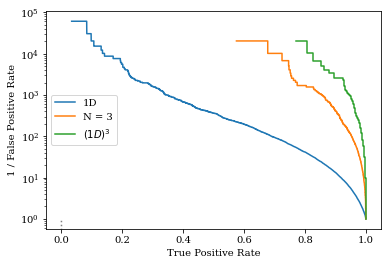

In [46]:
plt.plot(tpr_1D_phys,1./fpr_1D_phys,label="1D")
plt.plot(tpr_nD_phys,1./fpr_nD_phys,label="N = "+str(n_phys))
plt.plot(tpr_nD_from1D_phys,1./fpr_nD_from1D_phys,label="$(1D)^{"+str(n_phys)+"}$")
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate")
plt.ylabel("1 / False Positive Rate")
plt.yscale("log")
plt.legend()

In [47]:
#Try with a PFN

In [48]:
X_nD_val_phys_pfn = np.reshape(X_nD_val_phys,[len(X_nD_val_phys),n_phys,4])
X_nD_train_phys_pfn = np.reshape(X_nD_train_phys,[len(X_nD_train_phys),n_phys,4])

In [49]:
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)

In [50]:
pfn = PFN(input_dim=X_nD_val_phys_pfn.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes,F_dropouts=0.1,latent_dropout=0.1)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_5 (Activation)       (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_5[0][0]               
____________________________________________________________________________________________

In [51]:
if (retrain):
    num_epoch = 100
    batch_size = int(0.1*len(X_nD_train_phys_pfn)) #was 5000
    historyf = pfn.fit(X_nD_train_phys_pfn, to_categorical(Y_nD_train_phys,2),
              epochs=num_epoch,
              batch_size=batch_size,
              validation_data=(X_nD_val_phys_pfn, to_categorical(Y_nD_val_phys,2)),
            verbose=1)
    
    plt.plot(historyf.history['val_loss'][5:-1])
    plt.plot(historyf.history['loss'][5:-1])
    pfn.save_weights("ensemblelearning/model_pfn.h5")
else:
    pfn.load_weights("ensemblelearning/model_pfn.h5")

In [52]:
scores_nD_phys_pfn = pfn.predict(X_nD_val_phys_pfn,batch_size=int(0.1*len(X_nD_train_phys)))

In [53]:
fpr_nD_phys_pfn, tpr_nD_phys_pfn, _ = roc_curve(Y_nD_val_phys, scores_nD_phys_pfn[:,1])

<ipython-input-54-79df545fee37>:11: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr_1D_phys,1./fpr_1D_phys,label="$f_{1}$",color="blue")
<ipython-input-54-79df545fee37>:12: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr_nD_phys,1./fpr_nD_phys,label="$f_{"+str(n_phys)+"}$",color="red")
<ipython-input-54-79df545fee37>:13: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr_nD_sort_phys,1./fpr_nD_sort_phys,label="$f_{"+str(n_phys)+"}$${}^{sorted}$",ls=":",color="red")
<ipython-input-54-79df545fee37>:14: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr_nD_phys_pfn,1./fpr_nD_phys_pfn,label="$f_{"+str(n_phys)+"}$${}^{PFN}$",ls="--",color="red")
<ipython-input-54-79df545fee37>:15: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr_nD_from1D_phys,1./fpr_nD_from1D_phys,label=r"$f_{1\rightarrow "+str(n_phys)+"}$",color="black")


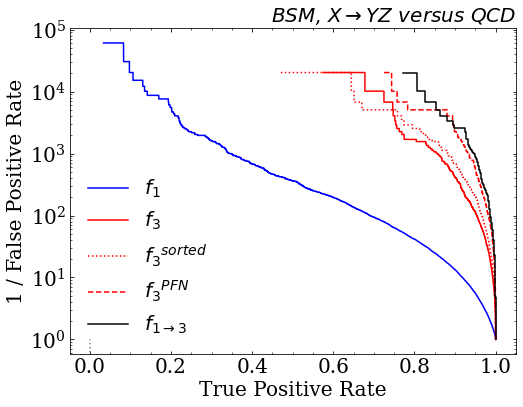

In [54]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

plt.plot(tpr_1D_phys,1./fpr_1D_phys,label="$f_{1}$",color="blue")
plt.plot(tpr_nD_phys,1./fpr_nD_phys,label="$f_{"+str(n_phys)+"}$",color="red")
plt.plot(tpr_nD_sort_phys,1./fpr_nD_sort_phys,label="$f_{"+str(n_phys)+"}$${}^{sorted}$",ls=":",color="red")
plt.plot(tpr_nD_phys_pfn,1./fpr_nD_phys_pfn,label="$f_{"+str(n_phys)+"}$${}^{PFN}$",ls="--",color="red")
plt.plot(tpr_nD_from1D_phys,1./fpr_nD_from1D_phys,label=r"$f_{1\rightarrow "+str(n_phys)+"}$",color="black")
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=20)
plt.ylabel("1 / False Positive Rate",fontsize=20)
plt.yscale("log")
plt.legend(frameon=False,fontsize=20)
plt.title(r"$BSM$, $X\rightarrow YZ$ $versus$ $QCD$",loc="right",fontsize=20)

plt.savefig("ensembleLearnPlots/BSM_ROC.pdf",bbox_inches='tight')

In [55]:
#Now, use a custom PFN loss

In [56]:
def myloss(y_true, y_pred):
    return binary_crossentropy(y_true,K.exp(y_pred)/(1.+K.exp(y_pred)))

In [57]:
Phi_sizes, F_sizes = (100, 100, 128, 1), []
pfn_v2 = PFN(input_dim=X_nD_val_phys_pfn.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes, output_dim=1, output_act='linear', Phi_acts=['relu','relu','relu','linear'],summary=False)
pfn_v2.model.layers.pop()
pfn_v2.model.layers.pop()
pfn_v2.model.compile(loss=lambda y_true, y_pred: myloss(y_true, y_pred), optimizer='adam', metrics=['accuracy'])
pfn_v2.model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_12 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_12[0][0]              
____________________________________________________________________________________________

In [58]:
if (retrain):
    historyf_v2 = pfn_v2.fit(X_nD_train_phys_pfn, Y_nD_train_phys,
              epochs=100,
              batch_size=batch_size,
              validation_data=(X_nD_val_phys_pfn, Y_nD_val_phys),
              verbose=1)
    pfn_v2.save_weights("ensemblelearning/model_pfn_v2.h5")
else:
    pfn_v2.load_weights("ensemblelearning/model_pfn_v2.h5")

In [59]:
scores_nD_phys_pfn_v2 = pfn_v2.predict(X_nD_val_phys_pfn,batch_size=int(0.1*len(X_nD_train_phys)))

In [60]:
fpr_nD_phys_pfn_v2, tpr_nD_phys_pfn_v2, _ = roc_curve(Y_nD_val_phys, scores_nD_phys_pfn_v2)

<ipython-input-61-7dcf7bec72ba>:1: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr_nD_phys_pfn,1./fpr_nD_phys_pfn,label="N = "+str(n_phys)+" (PFN)")
<ipython-input-61-7dcf7bec72ba>:2: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr_nD_phys_pfn_v2,1./fpr_nD_phys_pfn_v2,label="N = "+str(n_phys)+" (PFN v2)")


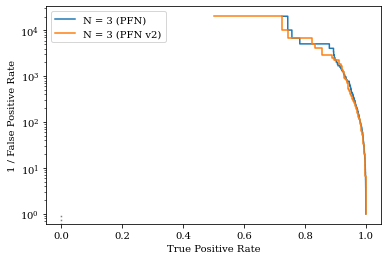

In [61]:
plt.plot(tpr_nD_phys_pfn,1./fpr_nD_phys_pfn,label="N = "+str(n_phys)+" (PFN)")
plt.plot(tpr_nD_phys_pfn_v2,1./fpr_nD_phys_pfn_v2,label="N = "+str(n_phys)+" (PFN v2)")
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate")
plt.ylabel("1 / False Positive Rate")
plt.yscale("log")
plt.legend()

In [62]:
myPhi = Model(pfn_v2.model.input,pfn_v2.model.layers[-4].output)

In [63]:
myPhi_preds = myPhi.predict(X_nD_val_phys_pfn,batch_size=int(0.1*len(X_nD_train_phys)))

In [64]:
preds_Phi = np.reshape(myPhi_preds,[n_phys*len(myPhi_preds)])
Y_Phi = [[Y_nD_val_phys[i],Y_nD_val_phys[i],Y_nD_val_phys[i]] for i in range(len(Y_nD_val_phys))]
Y_Phi = np.reshape(Y_Phi,[n_phys*len(Y_Phi)])

In [65]:
fpr_Phi, tpr_Phi, _ = roc_curve(Y_Phi, preds_Phi)

<ipython-input-66-fb11e34b8f21>:11: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr_1D_phys,1./fpr_1D_phys,label="$f_{1}$",color="blue")
<ipython-input-66-fb11e34b8f21>:12: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr_Phi,1./fpr_Phi,label=r"$f_{3\rightarrow 1}$",color="orange")
<ipython-input-66-fb11e34b8f21>:14: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr_nD_phys_pfn,1./fpr_nD_phys_pfn,label="$f_{"+str(n_phys)+"}$${}^{PFN}$",color="green")
<ipython-input-66-fb11e34b8f21>:15: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr_nD_phys_pfn_v2,1./fpr_nD_phys_pfn_v2,label="$f_{"+str(n_phys)+"}$${}^{PFN}$ (fixed F)",color="orange",ls=":")


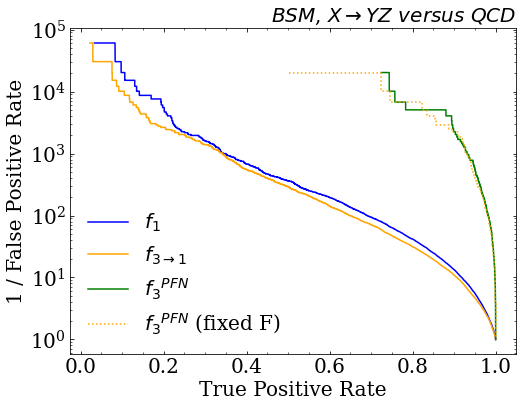

In [66]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

plt.plot(tpr_1D_phys,1./fpr_1D_phys,label="$f_{1}$",color="blue")
plt.plot(tpr_Phi,1./fpr_Phi,label=r"$f_{3\rightarrow 1}$",color="orange")

plt.plot(tpr_nD_phys_pfn,1./fpr_nD_phys_pfn,label="$f_{"+str(n_phys)+"}$${}^{PFN}$",color="green")
plt.plot(tpr_nD_phys_pfn_v2,1./fpr_nD_phys_pfn_v2,label="$f_{"+str(n_phys)+"}$${}^{PFN}$ (fixed F)",color="orange",ls=":")

plt.xlabel("True Positive Rate",fontsize=20)
plt.ylabel("1 / False Positive Rate",fontsize=20)
plt.yscale("log")
plt.legend(frameon=False,fontsize=20)

plt.title(r"$BSM$, $X\rightarrow YZ$ $versus$ $QCD$",loc="right",fontsize=20)
plt.savefig("ensembleLearnPlots/BSM_ROC2.pdf",bbox_inches='tight')

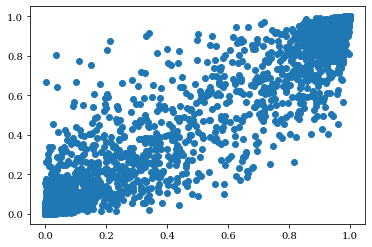

In [67]:
plt.scatter(scores_nD_phys_pfn[:,1],np.exp(scores_nD_phys_pfn_v2)/(1+np.exp(scores_nD_phys_pfn_v2)))

In [68]:
orig = scores_nD_phys_pfn[:,1]
new = np.exp(scores_nD_phys_pfn_v2)/(1+np.exp(scores_nD_phys_pfn_v2))

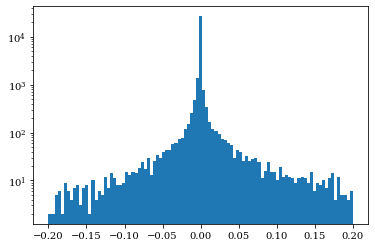

In [69]:
_,_,_=plt.hist(orig-new[:,0],bins=np.linspace(-0.2,0.2,100))
plt.yscale("log")

## Now let's do a harder classification task - top quark mass

In [70]:
test_dataset_0 = np.load('/global/home/users/bpnachman/data/bpnachman/Top/SRGN_Mt_default.npz')
test_dataset_1 = np.load('/global/home/users/bpnachman/data/bpnachman/Top/SRGN_Mt_unknown.npz')
test_dataset_variable = np.load('/global/home/users/bpnachman/data/bpnachman/Top/DCTR_Mt_train.npz')

In [71]:
def preprocess_data(X):
    return X / 1000.

In [72]:
X0_test_G = preprocess_data(test_dataset_0['generator'])
X0_test_S = preprocess_data(test_dataset_0['simulation'])
X1_test_G = preprocess_data(test_dataset_1['generator'])
X1_test_S = preprocess_data(test_dataset_1['simulation'])
X_interpolate = preprocess_data(test_dataset_variable['X'])
Y_interpolate = test_dataset_variable['Y'] #1 has variable top mass, 0 has fixed top mass.  Might need to reassign the rando masses in the fixed case.

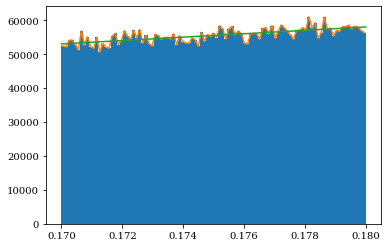

In [73]:
#Check that the distribution of thetas = top mass are the same for both the reference sample and the varied mass sample for learning the parameterized classifier.
#N.B. they are not!  This is because of a mass-dependent event selection.
n,b,_=plt.hist(X_interpolate[Y_interpolate==1][:,4],bins=np.linspace(0.17,0.18,100))

z= np.polyfit(0.5*(b[1:]+b[:-1]), n, 1)
p = np.poly1d(z)

plt.plot(0.5*(b[1:]+b[:-1]), n)
plt.plot(np.linspace(0.17,0.18,20),p(np.linspace(0.17,0.18,20)))

In [74]:
#let's make a new dataset with exactly the same distribution of thetas = top mass.

X_interpolate2 = X_interpolate.copy()

newthetas = X_interpolate[Y_interpolate==1][:,4][np.random.randint(0,len(X_interpolate[Y_interpolate==1]),len(X_interpolate[Y_interpolate==0]))]

X_interpolate2_0 = X_interpolate2[Y_interpolate==0]
X_interpolate2_1 = X_interpolate2[Y_interpolate==1]

X_interpolate2_0[:,4] = newthetas

X_interpolate2 = np.concatenate([X_interpolate2_0,X_interpolate2_1])
Y_interpolate2 = np.concatenate([np.zeros(len(X_interpolate2_0)),np.ones(len(X_interpolate2_1))])

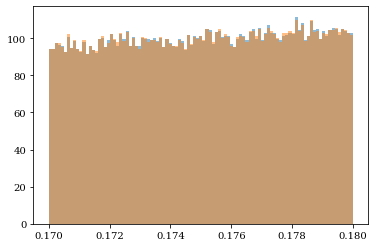

In [75]:
n,b,_=plt.hist(X_interpolate2[Y_interpolate2==0][:,4],bins=np.linspace(0.17,0.18,100),alpha=0.5,density=True)
n2,b2,_=plt.hist(X_interpolate2[Y_interpolate2==1][:,4],bins=np.linspace(0.17,0.18,100),alpha=0.5,density=True)

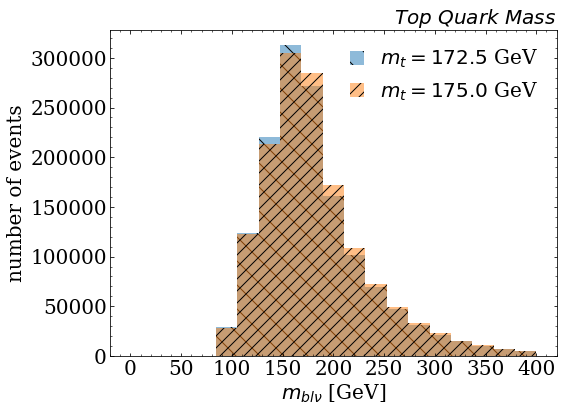

In [76]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

_,_,_=plt.hist(X0_test_S[:,0]*1000,bins=np.linspace(0,400,20),alpha=0.5,label="$m_t = 172.5$ GeV",hatch='\\')
_,_,_=plt.hist(X1_test_S[:,0]*1000,bins=np.linspace(0,400,20),alpha=0.5,label="$m_t = 175.0$ GeV",hatch='//')
plt.xlabel(r"$m_{bl\nu}$ [GeV]",fontsize=20)
plt.legend(frameon=False,fontsize=20,handlelength=0.7)
plt.ylabel("number of events",fontsize=20)

plt.title(r"$Top$ $Quark$ $Mass$",loc="right",fontsize=20)
plt.savefig("ensembleLearnPlots/Top_Features.pdf",bbox_inches='tight')

In [77]:
n_top = 20

X0_test_S = preprocess_data(test_dataset_0['generator'])
X1_test_S = preprocess_data(test_dataset_1['generator'])

X0_test_S = X0_test_S[0:len(X0_test_S) - len(X0_test_S) % n_top]
X1_test_S = X1_test_S[0:len(X1_test_S) - len(X1_test_S) % n_top]

X_1D_top = np.concatenate([X0_test_S,X1_test_S])
Y_1D_top = np.concatenate([np.ones(len(X0_test_S)),np.zeros(len(X1_test_S))])
    
X_nD_top = np.reshape(X_1D_top,[int(len(X_1D_top)/n_top),4*n_top])
Y_nD_top = np.concatenate([np.ones(int(len(X0_test_S)/n_top)),np.zeros(int(len(X1_test_S)/n_top))])

scaler_top = preprocessing.StandardScaler().fit(X_nD_top)
X_nD_top = scaler_top.transform(X_nD_top)

scaler_1D_top = preprocessing.StandardScaler().fit(X_1D_top)
X_1D_top = scaler_1D_top.transform(X_1D_top)

if (retrain):
    np.save("ensemblelearning/X_1D_top_train",X_1D_top_train)
    np.save("ensemblelearning/X_1D_top_val",X_1D_top_val)
    np.save("ensemblelearning/Y_1D_top_train",Y_1D_top_train)
    np.save("ensemblelearning/Y_1D_top_val",Y_1D_top_val)
    
    np.save("ensemblelearning/X_nD_top_train",X_nD_top_train)
    np.save("ensemblelearning/X_nD_top_val",X_nD_top_val)
    np.save("ensemblelearning/Y_nD_top_train",Y_nD_top_train)
    np.save("ensemblelearning/Y_nD_top_val",Y_nD_top_val)
    
    np.save("ensemblelearning/X_param_top_train",X_param_top_train)
    np.save("ensemblelearning/X_param_top_val",X_param_top_val)
    np.save("ensemblelearning/Y_param_top_train",Y_param_top_train)
    np.save("ensemblelearning/Y_param_top_val",Y_param_top_val)
    
    np.save("ensemblelearning/X2_param_top_train",X2_param_top_train)
    np.save("ensemblelearning/X2_param_top_val",X2_param_top_val)
    np.save("ensemblelearning/Y2_param_top_train",Y2_param_top_train)
    np.save("ensemblelearning/Y2_param_top_val",Y2_param_top_val)

    X_1D_top_train, X_1D_top_val, Y_1D_top_train, Y_1D_top_val = train_test_split(X_1D_top, Y_1D_top, test_size=0.5)
    X_nD_top_train, X_nD_top_val, Y_nD_top_train, Y_nD_top_val = train_test_split(X_nD_top, Y_nD_top, test_size=0.5)

    X_param_top_train, X_param_top_val, Y_param_top_train, Y_param_top_val = train_test_split(X_interpolate, Y_interpolate, test_size=0.5)
    X2_param_top_train, X2_param_top_val, Y2_param_top_train, Y2_param_top_val = train_test_split(X_interpolate2, Y_interpolate2, test_size=0.5)
else:
    X_1D_top_train = np.load("ensemblelearning/X_1D_top_train.npy")
    X_1D_top_val = np.load("ensemblelearning/X_1D_top_val.npy")
    Y_1D_top_train = np.load("ensemblelearning/Y_1D_top_train.npy")
    Y_1D_top_val = np.load("ensemblelearning/Y_1D_top_val.npy")
    
    X_nD_top_train = np.load("ensemblelearning/X_nD_top_train.npy")
    X_nD_top_val = np.load("ensemblelearning/X_nD_top_val.npy")
    Y_nD_top_train = np.load("ensemblelearning/Y_nD_top_train.npy")
    Y_nD_top_val = np.load("ensemblelearning/Y_nD_top_val.npy")
    
    X_param_top_train = np.load("ensemblelearning/X_param_top_train.npy")
    X_param_top_val = np.load("ensemblelearning/X_param_top_val.npy")
    Y_param_top_train = np.load("ensemblelearning/Y_param_top_train.npy")
    Y_param_top_val = np.load("ensemblelearning/Y_param_top_val.npy")
    
    X2_param_top_train = np.load("ensemblelearning/X2_param_top_train.npy")
    X2_param_top_val = np.load("ensemblelearning/X2_param_top_val.npy")
    Y2_param_top_train = np.load("ensemblelearning/Y2_param_top_train.npy")
    Y2_param_top_val = np.load("ensemblelearning/Y2_param_top_val.npy")

In [78]:
from tensorflow.keras.utils import to_categorical

In [79]:
#Let's learn a parameterized model
earlystopping = EarlyStopping(patience=20,
                              verbose=1,
                              restore_best_weights=True)

if (retrain):
    modelp_top = Sequential()
    modelp_top.add(Dense(50, activation='relu',input_shape =(5,))) 
    modelp_top.add(Dense(50, activation='relu'))
    modelp_top.add(Dense(50, activation='relu'))
    modelp_top.add(Dense(2, activation='softmax'))
    modelp_top.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    hist_top_modelp= modelp_top.fit(X_param_top_train, to_categorical(Y_param_top_train), epochs=200, batch_size=1000,validation_data=(X_param_top_val, to_categorical(Y_param_top_val)),callbacks=[earlystopping])

    model_json = modelp_top.to_json()
    with open("ensemblelearning/modelp_top.json", "w") as json_file:
        json_file.write(model_json)
    modelp_top.save_weights("ensemblelearning/modelp_top.h5")
else:
    json_file = open('ensemblelearning/modelp_top.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    modelp_top = model_from_json(loaded_model_json)
    modelp_top.load_weights("ensemblelearning/modelp_top.h5") 

Text(0.5, 0, '$m_{bl\\nu}$ [GeV]')

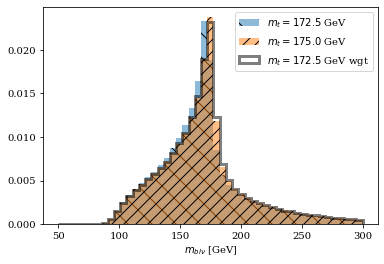

In [80]:
n0,_,_=plt.hist(X0_test_S[:,0]*1000,bins=np.linspace(50,300,50),alpha=0.5,label="$m_t = 172.5$ GeV",hatch='\\',density=True)
n1,_,_=plt.hist(X1_test_S[:,0]*1000,bins=np.linspace(50,300,50),alpha=0.5,label="$m_t = 175.0$ GeV",hatch='//',density=True)

mt = 175./1000.
tt = np.append(X0_test_S,mt*np.ones([len(X0_test_S),1]),1)
nn = modelp_top.predict(tt,batch_size=int(0.1*len(X_param_top_train)))
nn = nn[:,1] / nn[:,0]
nn = np.clip(nn,0,10)
n0_rw,_,_=plt.hist(X0_test_S[:,0]*1000,bins=np.linspace(50,300,50),alpha=0.5,label="$m_t = 172.5$ GeV wgt",histtype='step',color="black",weights=nn,density=True,linewidth=3)
plt.legend()
plt.xlabel(r"$m_{bl\nu}$ [GeV]")

<ipython-input-81-96bf4f4290a2>:1: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(n0/n1,label="Before reweighting")
<ipython-input-81-96bf4f4290a2>:2: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(n0_rw/n1,label="After reweighting")


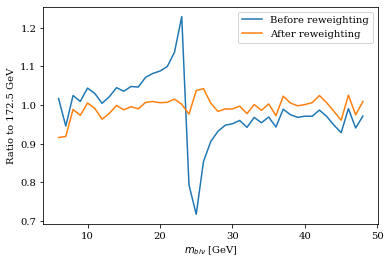

In [81]:
plt.plot(n0/n1,label="Before reweighting")
plt.plot(n0_rw/n1,label="After reweighting")
plt.xlabel(r"$m_{bl\nu}$ [GeV]")
plt.ylabel("Ratio to 172.5 GeV")
plt.legend()

In [82]:
logpvals = []
mtsvals = np.linspace(170,180.,20)
for mts in mtsvals:
    mt = mts/1000.
    tt = np.append(X0_test_S,mt*np.ones([len(X0_test_S),1]),1)
    nn = modelp_top.predict(tt,batch_size=int(0.1*len(X_param_top_train)))
    nn = nn[:,1] / nn[:,0]
    cor_val = p(mt)
    nn*=1./cor_val
    logpvals+=[-np.mean(np.log(nn))]
    
logpvals2 = []
for mts in mtsvals:
    mt = mts/1000.
    tt = np.append(X1_test_S,mt*np.ones([len(X1_test_S),1]),1)
    nn = modelp_top.predict(tt,batch_size=int(0.1*len(X_param_top_train)))
    nn = nn[:,1] / nn[:,0]
    cor_val = p(mt)
    nn*=1./cor_val
    logpvals2+=[-np.mean(np.log(nn))]

In [83]:
logpvalsb = []
mtsvals = np.linspace(170,180.,20)
for mts in mtsvals:
    mt = mts/1000.
    tt = np.append(X0_test_S,mt*np.ones([len(X0_test_S),1]),1)
    nn = modelp_top.predict(tt,batch_size=int(0.1*len(X_param_top_train)))
    nn = nn[:,1] / nn[:,0]
    logpvalsb+=[-np.mean(np.log(nn))]
    
logpvals2b = []
for mts in mtsvals:
    mt = mts/1000.
    tt = np.append(X1_test_S,mt*np.ones([len(X1_test_S),1]),1)
    nn = modelp_top.predict(tt,batch_size=int(0.1*len(X_param_top_train)))
    nn = nn[:,1] / nn[:,0]
    logpvals2b+=[-np.mean(np.log(nn))]

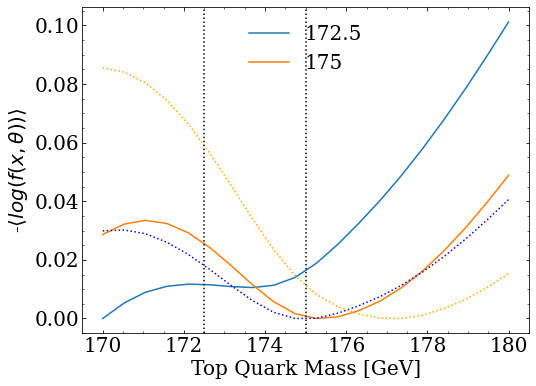

In [84]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

plt.plot(mtsvals,logpvals-min(logpvals),label="172.5")
plt.plot(mtsvals,logpvals2-min(logpvals2),label="175")
plt.plot(mtsvals,logpvalsb-min(logpvalsb),color="blue",ls=":")
plt.plot(mtsvals,logpvals2b-min(logpvals2b),color="orange",ls=":")
plt.axvline(172.5,color="black",ls=":")
plt.axvline(175,color="black",ls=":")
plt.xlabel("Top Quark Mass [GeV]",fontsize=20)
plt.ylabel(r"-$\langle log(f(x,\theta)) \rangle$",fontsize=20)
plt.legend(frameon=False,fontsize=20)

In [465]:
for i in range(10):
    model_json = modelp2_tops[i].to_json()
    with open("ensemblelearning/modelp2_tops_"+str(i)+".json", "w") as json_file:
        json_file.write(model_json)
    modelp2_tops[i].save_weights("ensemblelearning/modelp2_tops_"+str(i)+".h5")

In [ ]:
#Train 10 models and take the median

modelp2_tops = {}
if (retrain):
    for i in range(10):
        print("on model = ",i)
        modelp2_tops[i] = Sequential()
        modelp2_tops[i].add(Dense(50, activation='relu',input_shape =(5,))) 
        modelp2_tops[i].add(Dense(50, activation='relu'))
        modelp2_tops[i].add(Dense(50, activation='relu'))
        modelp2_tops[i].add(Dense(2, activation='softmax'))
        modelp2_tops[i].compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        hist_top_modelp2= modelp2_tops[i].fit(X2_param_top_train, to_categorical(Y2_param_top_train), epochs=200, batch_size=1000,validation_data=(X2_param_top_val, to_categorical(Y2_param_top_val)),callbacks=[earlystopping])
        
        model_json = modelp2_tops[i].to_json()
        with open("ensemblelearning/modelp2_tops_"+str(i)+".json", "w") as json_file:
            json_file.write(model_json)
        modelp2_tops[i].save_weights("ensemblelearning/modelp2_tops_"+str(i)+".h5")
else:
    for i in range(10):
            json_file = open('ensemblelearning/modelp2_tops_'+str(i)+'.json', 'r')
            loaded_model_json = json_file.read()
            json_file.close()
            modelp2_tops[i] = model_from_json(loaded_model_json)
            modelp2_tops[i].load_weights("ensemblelearning/modelp2_tops_"+str(i)+".h5") 

In [85]:
if (retrain):
    modelp2_top = Sequential()
    modelp2_top.add(Dense(50, activation='relu',input_shape =(5,))) 
    modelp2_top.add(Dense(50, activation='relu'))
    modelp2_top.add(Dense(50, activation='relu'))
    modelp2_top.add(Dense(2, activation='softmax'))
    modelp2_top.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    hist_top_modelp2= modelp2_top.fit(X2_param_top_train, to_categorical(Y2_param_top_train), epochs=200, batch_size=1000,validation_data=(X2_param_top_val, to_categorical(Y2_param_top_val)),callbacks=[earlystopping])

    model_json = modelp2_top.to_json()
    with open("ensemblelearning/modelp2_top.json", "w") as json_file:
        json_file.write(model_json)
    modelp2_top.save_weights("ensemblelearning/modelp2_top.h5")
else:
    json_file = open('ensemblelearning/modelp2_top.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    modelp2_top = model_from_json(loaded_model_json)
    modelp2_top.load_weights("ensemblelearning/modelp2_top.h5") 

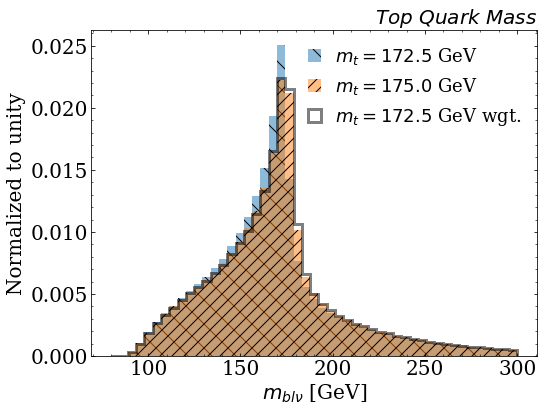

In [284]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

n0,_,_=plt.hist(X0_test_S[:,0]*1000,bins=np.linspace(80,300,50),alpha=0.5,label="$m_t = 172.5$ GeV",hatch='\\',density=True)
n1,_,_=plt.hist(X1_test_S[:,0]*1000,bins=np.linspace(80,300,50),alpha=0.5,label="$m_t = 175.0$ GeV",hatch='//',density=True)

mt = 175./1000.
tt = np.append(X0_test_S,mt*np.ones([len(X0_test_S),1]),1)
nn = modelp2_top.predict(tt,batch_size=int(0.1*len(X_param_top_train)))
nn = nn[:,1] / nn[:,0]
nn = np.clip(nn,0,10)
n0_rw,_,_=plt.hist(X0_test_S[:,0]*1000,bins=np.linspace(80,300,50),alpha=0.5,label="$m_t = 172.5$ GeV wgt.",histtype='step',color="black",weights=nn,density=True,linewidth=3)
plt.legend(frameon=False,fontsize=18,handlelength=0.7)
plt.xlabel(r"$m_{bl\nu}$ [GeV]",fontsize=20)
plt.ylabel(r"Normalized to unity",fontsize=20)

plt.title(r"$Top$ $Quark$ $Mass$",loc="right",fontsize=20)
plt.savefig("ensembleLearnPlots/Top_Features_withwrgt.pdf",bbox_inches='tight')

<ipython-input-285-96bf4f4290a2>:1: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(n0/n1,label="Before reweighting")
<ipython-input-285-96bf4f4290a2>:2: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(n0_rw/n1,label="After reweighting")


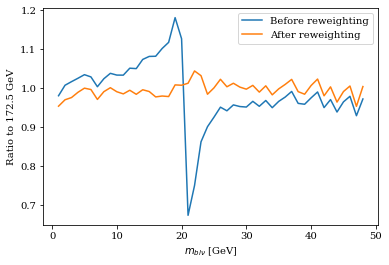

In [285]:
plt.plot(n0/n1,label="Before reweighting")
plt.plot(n0_rw/n1,label="After reweighting")
plt.xlabel(r"$m_{bl\nu}$ [GeV]")
plt.ylabel("Ratio to 172.5 GeV")
plt.legend()

In [344]:
nn_hold = modelp2_tops[i].predict(tt,batch_size=int(0.1*len(X_param_top_train)))
nn_hold = nn_hold[:,1] / nn_hold[:,0]

In [346]:
nns = [nn_hold,nn_hold,nn_hold,nn_hold,nn_hold]

In [348]:
np.shape(nns)

(5, 1465100)

In [368]:
np.shape(stats.trim_mean(nns,0.25,axis=0))
np.shape(np.median(nns,axis=0))

(5496466,)

In [372]:
np.mean(-np.log(nns),axis=1)

array([-1.3323544, -1.3383183, -1.3275777, -1.3228399, -1.321086 ,
       -1.3207016, -1.2987095, -1.3042955, -1.2978449, -1.3259488],
      dtype=float32)

In [366]:
from scipy import stats

In [462]:
logpvals = []
mtsvals = np.linspace(170,180.,100)
for mts in mtsvals:
    print(mts)
    mt = mts/1000.
    tt = np.append(X0_test_S,mt*np.ones([len(X0_test_S),1]),1)
    nns = []
    for i in range(10):
        nn_hold = modelp2_tops[i].predict(tt,batch_size=int(0.1*len(X_param_top_train)))
        nn_hold = nn_hold[:,1] / nn_hold[:,0]
        nns+=[nn_hold]
    #nn = np.median(nns,axis=0)
    #logpvals+=[-np.mean(np.log(nn))]
    logpvals+=[np.median(np.mean(-np.log(nns),axis=1))]
    
logpvals2 = []
for mts in mtsvals:
    print(mts)
    mt = mts/1000.
    tt = np.append(X1_test_S,mt*np.ones([len(X1_test_S),1]),1)
    nns = []
    for i in range(10):
        nn_hold = modelp2_tops[i].predict(tt,batch_size=int(0.1*len(X_param_top_train)))
        nn_hold = nn_hold[:,1] / nn_hold[:,0]
        nns+=[nn_hold]
    #nn = np.median(nns,axis=0)
    #logpvals2+=[-np.mean(np.log(nn))]
    logpvals2+=[np.median(np.mean(-np.log(nns),axis=1))]

170.0
170.1010101010101
170.2020202020202
170.3030303030303
170.40404040404042
170.5050505050505
170.6060606060606
170.7070707070707
170.8080808080808
170.9090909090909
171.010101010101
171.11111111111111
171.21212121212122
171.31313131313132
171.41414141414143
171.5151515151515
171.6161616161616
171.7171717171717
171.8181818181818
171.91919191919192
172.02020202020202
172.12121212121212
172.22222222222223
172.32323232323233
172.42424242424244
172.5252525252525
172.62626262626262
172.72727272727272
172.82828282828282
172.92929292929293
173.03030303030303
173.13131313131314
173.23232323232324
173.33333333333334
173.43434343434345
173.53535353535352
173.63636363636363
173.73737373737373
173.83838383838383
173.93939393939394
174.04040404040404
174.14141414141415
174.24242424242425
174.34343434343435
174.44444444444446
174.54545454545453
174.64646464646464
174.74747474747474
174.84848484848484
174.94949494949495
175.05050505050505
175.15151515151516
175.25252525252526
175.35353535353536
17

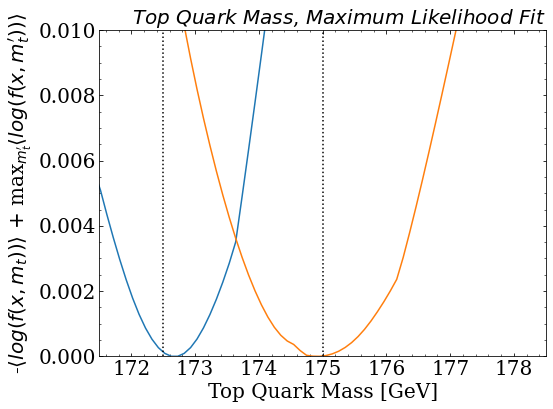

In [463]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

plt.plot(mtsvals,logpvals-min(logpvals)) #try this tomrorow
plt.plot(mtsvals,logpvals2-min(logpvals2))
plt.axvline(175,color="black",ls=":")
plt.axvline(172.5,color="black",ls=":")
plt.xlabel("Top Quark Mass [GeV]",fontsize=20)
plt.ylabel(r"-$\langle log(f(x,m_t)) \rangle$ + max$_{m_t'}\langle log(f(x,m_t')) \rangle$",fontsize=20)
#plt.legend(frameon=False,fontsize=20)
plt.xlim([175-3.5,175+3.5])
plt.ylim([0,0.01])
plt.title("$Top$ $Quark$ $Mass$, $Maximum$ $Likelihood$ $Fit$",loc="right",fontsize=20)
plt.savefig("ensembleLearnPlots/TopMassRegressionMLE.pdf",bbox_inches='tight')

Now, prepare the code for the direct regression / maximum likelihood evaluation test.

In [401]:
mtsvals = np.linspace(160,190.,50)
myvec1 = X_interpolate[Y_interpolate==1].copy()
nnvec = {}
for mts in mtsvals:
    print(mts)
    mt = mts/1000.
    tt = np.append(myvec1[:,0:4],mt*np.ones([len(myvec1),1]),1)
    #nn = modelp2_top.predict(tt,batch_size=int(0.1*len(X_param_top_train)))
    #nn = nn[:,1] / nn[:,0]
    
    nns = []
    for i in range(10):
        nn_hold = modelp2_tops[i].predict(tt,batch_size=int(0.1*len(X_param_top_train)))
        nn_hold = nn_hold[:,1] / nn_hold[:,0]
        nns+=[nn_hold]
    nnvec[mts] = nns #np.median(nns,axis=0)

160.0
160.6122448979592
161.22448979591837
161.83673469387756
162.44897959183675
163.0612244897959
163.6734693877551
164.28571428571428
164.89795918367346
165.51020408163265
166.12244897959184
166.73469387755102
167.3469387755102
167.9591836734694
168.57142857142858
169.18367346938777
169.79591836734693
170.40816326530611
171.0204081632653
171.6326530612245
172.24489795918367
172.85714285714286
173.46938775510205
174.08163265306123
174.69387755102042
175.30612244897958
175.91836734693877
176.53061224489795
177.14285714285714
177.75510204081633
178.3673469387755
178.9795918367347
179.59183673469389
180.20408163265307
180.81632653061223
181.42857142857144
182.0408163265306
182.6530612244898
183.26530612244898
183.87755102040816
184.48979591836735
185.10204081632654
185.71428571428572
186.3265306122449
186.9387755102041
187.55102040816325
188.16326530612244
188.77551020408163
189.3877551020408
190.0


In [402]:
myvec = X_interpolate[Y_interpolate==1][:,4].copy()
hold = myvec[0]
splits = []
ind_masses = []
hold_vec = []
input_vals = []
output_vals = []
new_array_X = np.zeros([149000,100,4])
new_array_Y = []
mycounter = 0
for i in range(len(myvec)):
    
    if (i%100000==0):
        print(i,1.*i/len(myvec))
    
    if (myvec[i]==hold):        
        hold_vec+=[i]
    else:
        logpvals = []
        for mts in mtsvals:
            #nn = nnvec[mts][hold_vec]
            nn = [nnvec[mts][j][hold_vec] for j in range(10)]
            #logpvals+=[-np.mean(np.log(nn))]
            logpvals+=[np.median(np.mean(-np.log(nn),axis=1))]
        #print(logpvals)
        #plt.plot(mtsvals,logpvals)
        if (mycounter < 149000 and len(hold_vec) > 0):
            new_array_X[mycounter][0:len(myvec1[hold_vec][:,0:4])]=myvec1[hold_vec][:,0:4]
            new_array_Y+=[myvec1[hold_vec][:,4][0]]
            mycounter+=1
            pass
        input_vals += [hold]
        output_vals += [mtsvals[np.argmin(logpvals)]]
        
        splits += [i]
        ind_masses += [hold]
        
        hold = myvec[i]
        hold_vec=[]
        #break

0 0.0
100000 0.018193508337902935


/global/home/users/bpnachman/anaconda3/envs/tf2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/global/home/users/bpnachman/anaconda3/envs/tf2/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


200000 0.03638701667580587
300000 0.05458052501370881
400000 0.07277403335161174
500000 0.09096754168951468
600000 0.10916105002741762
700000 0.12735455836532056
800000 0.14554806670322348
900000 0.16374157504112644
1000000 0.18193508337902936
1100000 0.20012859171693229
1200000 0.21832210005483524
1300000 0.23651560839273816
1400000 0.2547091167306411
1500000 0.27290262506854407
1600000 0.29109613340644697
1700000 0.3092896417443499
1800000 0.32748315008225287
1900000 0.34567665842015577
2000000 0.3638701667580587
2100000 0.3820636750959617
2200000 0.40025718343386457
2300000 0.4184506917717675
2400000 0.4366442001096705
2500000 0.45483770844757343
2600000 0.4730312167854763
2700000 0.4912247251233793
2800000 0.5094182334612822
2900000 0.5276117417991851
3000000 0.5458052501370881
3100000 0.563998758474991
3200000 0.5821922668128939
3300000 0.6003857751507969
3400000 0.6185792834886998
3500000 0.6367727918266027
3600000 0.6549663001645057
3700000 0.6731598085024086
3800000 0.691353316

Text(1.0, 1.0, '$Top$ $Quark$ $Mass$, $Maximum$ $Likelihood$ $Fit$')

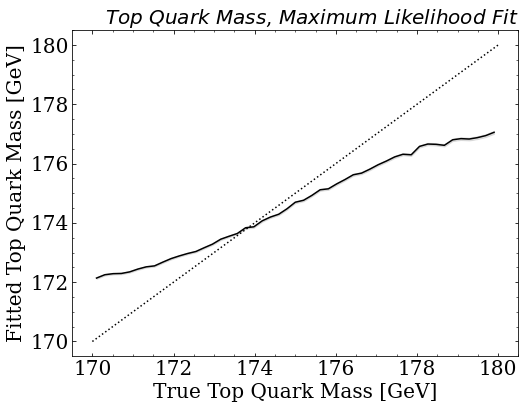

In [403]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

input_vals = np.array(input_vals)
output_vals = np.array(output_vals)

input_vals2 = input_vals[(output_vals > 170.5) & (output_vals < 179.5)] #bad edge effects - remove extreme points
output_vals2 = output_vals[(output_vals > 170.5) & (output_vals < 179.5)]

nbins = 50
mybins = np.linspace(0.17,0.18,nbins)
mymeans = np.array([np.mean(output_vals2[(input_vals2 > mybins[i]) & (input_vals2 < mybins[i+1])]) for i in range(nbins-1)])
mystds = np.array([np.std(output_vals2[(input_vals2 > mybins[i]) & (input_vals2 < mybins[i+1])]) for i in range(nbins-1)])
myns = np.array([len(output_vals2[(input_vals2 > mybins[i]) & (input_vals2 < mybins[i+1])]) for i in range(nbins-1)])
plt.plot(1000*0.5*(mybins[1:]+mybins[:-1]),mymeans,color="black")
plt.fill_between(1000*0.5*(mybins[1:]+mybins[:-1]),mymeans-mystds/myns**0.5,mymeans+mystds/myns**0.5,color="black",alpha=0.1)
plt.plot([170,180],[170,180],ls=":",color="black")
#plt.xlim([174,176])
#plt.ylim([174,176])
plt.xlabel("True Top Quark Mass [GeV]",fontsize=20)
plt.ylabel("Fitted Top Quark Mass [GeV]",fontsize=20)
#plt.xticks([174.5,175,175.5,176])
#plt.yticks([174,174.5,175,175.5,176])
plt.title("$Top$ $Quark$ $Mass$, $Maximum$ $Likelihood$ $Fit$",loc="right",fontsize=20)

In [93]:
runs = [splits[i]-splits[i-1] for i in range(1,len(splits))]

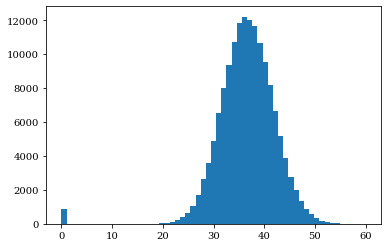

In [94]:
_,_,_=plt.hist(runs,bins=np.linspace(0,60,60))
#This is because of the event selection.  We actually simulated a fixed number.

In [95]:
#Direct regression

Phi_sizes, F_sizes = (100, 100, 128), [100,100,100]
pfn_topregression = PFN(input_dim=new_array_X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes, output_dim=1, output_act='linear', Phi_acts='relu',summary=False,F_dropouts=0.05)
pfn_topregression.model.compile(loss="mse", optimizer='adam', metrics=['accuracy'])
#pfn_topregression.model.summary()

In [96]:
new_array_X = np.array(new_array_X)
new_array_Y = np.array(new_array_Y)

In [97]:
num_epoch = 200
batch_size = int(0.01*len(new_array_X))
if (retrain):
    #looked at plt.hist((top_regr_true-0.175)/0.002) and this approximately standardizes
    history_topreg = pfn_topregression.fit(5*new_array_X[0:int(0.5*len(new_array_X))]-1, 500*(new_array_Y[0:int(0.5*len(new_array_X))]-0.175),
              epochs=num_epoch,
              batch_size=500,
              validation_data=(5*new_array_X[int(0.5*len(new_array_X)):-1]-1, 500*(new_array_Y[int(0.5*len(new_array_X)):-1]-0.175)),
            verbose=1,callbacks=[earlystopping])

    pfn_topregression.save_weights("ensemblelearning/pfn_topregression.h5")
    
    plt.plot(history_topreg.history['val_loss'],label="val")
    plt.plot(history_topreg.history['loss'],label="train")
    #plt.ylim([0,0.004])
    plt.yscale('log')
    plt.legend()

else:
    pfn_topregression.load_weights("ensemblelearning/pfn_topregression.h5")

In [98]:
top_regr_predict = pfn_topregression.predict(5*new_array_X[int(0.5*len(new_array_X)):-1]-1)
top_regr_true = new_array_Y[int(0.5*len(new_array_X)):-1]

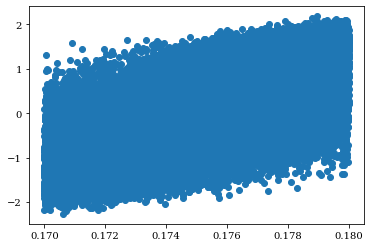

In [99]:
plt.scatter(top_regr_true,top_regr_predict)

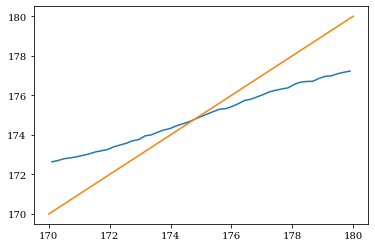

In [100]:
mybins = np.linspace(0.17,0.18,nbins)
mymeans_regr = np.array([np.mean(top_regr_predict[(top_regr_true > mybins[i]) & (top_regr_true < mybins[i+1])]) for i in range(nbins-1)])

plt.plot(1000*0.5*(mybins[1:]+mybins[:-1]),1000*(0.002*mymeans_regr+0.175))
plt.plot([170,180],[170,180])

In [101]:
np.shape(new_array_X)

(149000, 100, 4)

In [102]:
new_array_X_flatten = np.reshape(new_array_X,[149000*100,4])

In [410]:
#Need to apply the median thing here
#Compare directly with the direct regression

num = np.zeros([10,149000])
den = np.zeros([10,149000])

for j in range(50):
    if (j%10==0):
        print("on j=",j)
    #mt = top_regr_true[np.random.randint(0,len(top_regr_true))]
    mt_hold = top_regr_true[np.random.randint(0,len(top_regr_true),len(new_array_Y))]
    mt = np.outer(mt_hold,np.ones(100))
    #tt = np.append(new_array_X_flatten,mt*np.ones([len(new_array_X_flatten),1]),1)
    tt = np.append(new_array_X_flatten,np.reshape(mt,[14900000, 1]),1)
    
    for i in range(10):
        nn = modelp2_tops[i].predict(tt,batch_size=int(0.1*len(new_array_X_flatten)))
        nn = nn[:,1] / nn[:,0]

        nn = np.reshape(nn,[149000,100])
        #zval = modelp2_top.predict([[0,0,0,0,mt]])[0][1]/modelp2_top.predict([[0,0,0,0,mt]])[0][0]
        #zval = nn[0][-1]
        zval = nn[:,-1]
        #nn[nn==zval]=1 #all of the zeros
        nn[nn==np.outer(zval,np.ones(100))]=1 #all of the zeros
        nn[nn!=np.ones(100)]*=1./3 #makes all of the products closer to 1.  We are allowed to multiply numerator and denominator by a fixed constant.
        num[i] += mt_hold*np.product(nn,axis=1)
        den[i] += np.product(nn,axis=1)

on j= 0
on j= 10
on j= 20
on j= 30
on j= 40


In [418]:
direct_vals = pfn_topregression.predict(5*new_array_X-1)

In [459]:
blahy_hold = [1000*num[0]/den[0]]
for i in range(1,10):
    blahy_hold += [1000*num[i]/den[i]]
    pass

<ipython-input-459-98fb9fbabdb3>:1: RuntimeWarning: invalid value encountered in true_divide
  blahy_hold = [1000*num[0]/den[0]]
<ipython-input-459-98fb9fbabdb3>:3: RuntimeWarning: invalid value encountered in true_divide
  blahy_hold += [1000*num[i]/den[i]]


/global/home/users/bpnachman/anaconda3/envs/tf2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/global/home/users/bpnachman/anaconda3/envs/tf2/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/global/home/users/bpnachman/anaconda3/envs/tf2/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/global/home/users/bpnachman/anaconda3/envs/tf2/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/global/home/users/bpnachman/anaconda3/envs/tf2/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

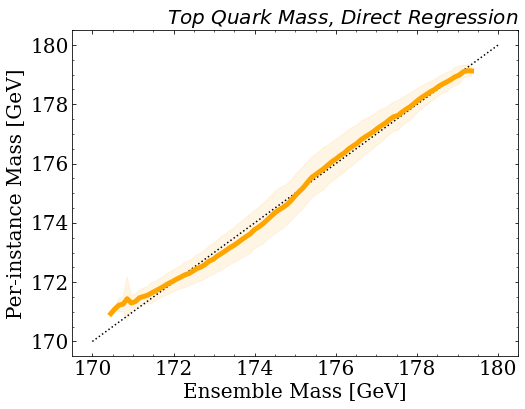

In [467]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

#plt.scatter(1000*(0.002*direct_vals+0.175),1000*num[0]/den[0])
plt.plot([170,180],[170,180],ls=":",color="black")

blahy = np.median(blahy_hold,axis=0) #np.array(1000*num[0]/den[0])
blahx = np.array(1000*(0.002*direct_vals+0.175)).flatten()

blahx = blahx[~np.isnan(blahy)]
blahy = blahy[~np.isnan(blahy)]

nbins = 100
mybins = np.linspace(170,180,nbins)
mymeans = np.array([np.mean(blahy[(blahx > mybins[i]) & (blahx < mybins[i+1])]) for i in range(nbins-1)])
mystds = np.array([np.std(blahy[(blahx > mybins[i]) & (blahx < mybins[i+1])]) for i in range(nbins-1)])

plt.plot(0.5*(mybins[1:]+mybins[:-1]),mymeans,ls="-",lw=5,color="orange")
plt.fill_between(0.5*(mybins[1:]+mybins[:-1]),mymeans-mystds,mymeans+mystds,color="orange",alpha=0.1)

plt.title("$Top$ $Quark$ $Mass$, $Direct$ $Regression$",loc="right",fontsize=20)

plt.xlabel("Ensemble Mass [GeV]",fontsize=20)
plt.ylabel("Per-instance Mass [GeV]",fontsize=20)
plt.savefig("ensembleLearnPlots/TopMassRegressionDirect.pdf",bbox_inches='tight')

In [315]:
true_vals = np.array(new_array_Y)
pred_vals = np.array(num/den)

true_vals = true_vals[~np.isnan(pred_vals)]
pred_vals = pred_vals[~np.isnan(pred_vals)]

<ipython-input-315-46c71e1afd22>:2: RuntimeWarning: invalid value encountered in true_divide
  pred_vals = np.array(num/den)


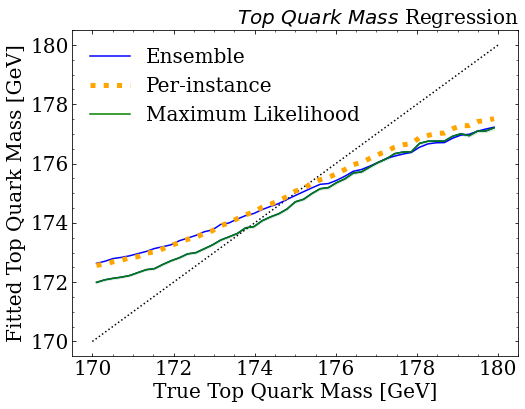

In [388]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

input_vals = np.array(input_vals)
output_vals = np.array(output_vals)

input_vals2 = input_vals[(output_vals > 170.5) & (output_vals < 179.5)] #bad edge effects - remove extreme points
output_vals2 = output_vals[(output_vals > 170.5) & (output_vals < 179.5)]

#input_vals2 = input_vals[(output_vals > 160.5) & (output_vals < 189.5)] #bad edge effects - remove extreme points
#output_vals2 = output_vals[(output_vals > 160.5) & (output_vals < 189.5)]

nbins = 50
mybins = np.linspace(0.17,0.18,nbins)
mymeans = np.array([np.mean(output_vals2[(input_vals2 > mybins[i]) & (input_vals2 < mybins[i+1])]) for i in range(nbins-1)])
mystds = np.array([np.std(output_vals2[(input_vals2 > mybins[i]) & (input_vals2 < mybins[i+1])]) for i in range(nbins-1)])
myns = np.array([len(output_vals2[(input_vals2 > mybins[i]) & (input_vals2 < mybins[i+1])]) for i in range(nbins-1)])
plt.plot(1000*0.5*(mybins[1:]+mybins[:-1]),mymeans,color="blue")
plt.fill_between(1000*0.5*(mybins[1:]+mybins[:-1]),mymeans-mystds/myns**0.5,mymeans+mystds/myns**0.5,color="green",alpha=0.1)
plt.plot([170,180],[170,180],ls=":",color="black")
#plt.xlim([174,176])
#plt.ylim([174,176])

mymeans_regr = np.array([np.mean(top_regr_predict[(top_regr_true > mybins[i]) & (top_regr_true < mybins[i+1])]) for i in range(nbins-1)])
mymeans_regr2 = np.array([np.mean(pred_vals[(true_vals > mybins[i]) & (true_vals < mybins[i+1])]) for i in range(nbins-1)])


plt.plot(1000*0.5*(mybins[1:]+mybins[:-1]),1000*(0.002*mymeans_regr+0.175),label="Ensemble",color="blue")
plt.plot(1000*0.5*(mybins[1:]+mybins[:-1]),1000*(mymeans_regr2),label="Per-instance",color="orange",ls=":",lw=5)
plt.plot(1000*0.5*(mybins[1:]+mybins[:-1]),mymeans,label="Maximum Likelihood",color="green")

plt.xlabel("True Top Quark Mass [GeV]",fontsize=20)
plt.ylabel("Fitted Top Quark Mass [GeV]",fontsize=20)
#plt.xticks([174.5,175,175.5,176])
#plt.yticks([174,174.5,175,175.5,176])
plt.legend(frameon=False,fontsize=20)
plt.title("$Top$ $Quark$ $Mass$ Regression",loc="right",fontsize=20)
plt.savefig("ensembleLearnPlots/TopMassRegression.pdf",bbox_inches='tight')

In [468]:
if (retrain):
    model1D_top = Sequential()
    model1D_top.add(Dense(128, activation='relu',input_shape =(4,))) 
    model1D_top.add(Dense(128, activation='relu'))
    model1D_top.add(Dense(1, activation='sigmoid'))
    model1D_top.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    hist_top_model1D= model1D_top.fit(X_1D_top_train, Y_1D_top_train, epochs=20, batch_size=int(0.1*len(X_1D_top_train)),validation_data=(X_1D_top_val, Y_1D_top_val))

    modelnD_top = Sequential()
    modelnD_top.add(Dense(128, activation='relu',input_shape =(4*n_top,))) 
    modelnD_top.add(Dense(128, activation='relu'))
    modelnD_top.add(Dense(1, activation='sigmoid'))
    modelnD_top.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    hist_top_modelnD= modelnD_top.fit(X_nD_top_train, Y_nD_top_train, epochs=20, batch_size=int(0.1*len(X_nD_top_train)),validation_data=(X_nD_top_val, Y_nD_top_val))

    model_json = model1D_top.to_json()
    with open("ensemblelearning/model1D_top.json", "w") as json_file:
        json_file.write(model_json)
    model1D_top.save_weights("ensemblelearning/model1D_top.h5")

    model_json = modelnD_top.to_json()
    with open("ensemblelearning/modelnD_top.json", "w") as json_file:
        json_file.write(model_json)
    modelnD_top.save_weights("ensemblelearning/modelnD_top.h5")
    
else:
    json_file = open('ensemblelearning/model1D_top.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model1D_top = model_from_json(loaded_model_json)
    model1D_top.load_weights("ensemblelearning/model1D_top.h5") 

    json_file = open('ensemblelearning/modelnD_top.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    modelnD_top = model_from_json(loaded_model_json)
    modelnD_top.load_weights("ensemblelearning/modelnD_top.h5")     
    
scores_1D_top = model1D_top.predict(X_1D_top_val,batch_size=int(0.1*len(X_nD_top_train)))
scores_nD_top = modelnD_top.predict(X_nD_top_val,batch_size=int(0.1*len(X_nD_top_train)))

scores_1D_fromnD_top = model1D_top.predict(scaler_1D_top.transform(np.reshape(scaler_top.inverse_transform(X_nD_top_val),[n_top*len(X_nD_top_val),4])),batch_size=int(0.1*len(X_nD_top_train)))
#scores_1D_fromnD_top = model1D_top.predict(np.reshape(X_nD_top_val,[n*len(X_nD_top_val)]))
scores_1D_fromnD_top = np.reshape(scores_1D_fromnD_top,[int(len(scores_1D_fromnD_top)/n_top),n_top])

scaled_up_top = np.array([np.prod(scores_1D_fromnD_top[i,:] / (1.-scores_1D_fromnD_top[i,:])) for i in range(len(scores_1D_fromnD_top))])
fpr_1D_top, tpr_1D_top, _ = roc_curve(Y_1D_top_val, scores_1D_top)
fpr_nD_top, tpr_nD_top, _ = roc_curve(Y_nD_top_val, scores_nD_top)
fpr_nD_from1D_top, tpr_nD_from1D_top, _ = roc_curve(Y_nD_top_val, scaled_up_top)

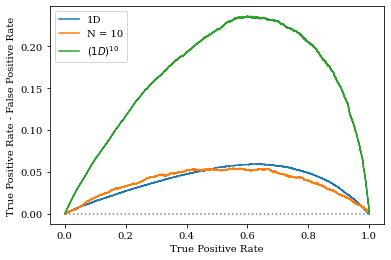

In [469]:
plt.plot(tpr_1D_top,1-fpr_1D_top-(1-tpr_1D_top),label="1D")
plt.plot(tpr_nD_top,1-fpr_nD_top-(1-tpr_nD_top),label="N = 10")
plt.plot(tpr_nD_from1D_top,1-fpr_nD_from1D_top-(1-tpr_nD_from1D_top),label="$(1D)^{10}$")
plt.plot([0,1],[0,0],ls=":",color="grey")
plt.xlabel("True Positive Rate")
plt.ylabel("True Positive Rate - False Positive Rate")
plt.legend()

In [470]:
X_nD_val_top_pfn = np.reshape(X_nD_top_val,[len(X_nD_top_val),n_top,4])
X_nD_train_top_pfn = np.reshape(X_nD_top_train,[len(X_nD_top_train),n_top,4])

Phi_sizes_top, F_sizes_top = (100, 100, 128), (100, 100, 100)
pfn_top = PFN(input_dim=X_nD_val_top_pfn.shape[-1], Phi_sizes=Phi_sizes_top, F_sizes=F_sizes_top)
num_epoch = 100
batch_size = 5000 #was 5000

if (retrain):
    historyf_top = pfn_top.fit(X_nD_train_top_pfn, to_categorical(Y_nD_top_train,2),
              epochs=num_epoch,
              batch_size=batch_size,
              validation_data=(X_nD_val_top_pfn, to_categorical(Y_nD_top_val,2)),
            verbose=1)
    model_json = pfn_top.model.to_json()
    with open("ensemblelearning/model_pfn_top.json", "w") as json_file:
        json_file.write(model_json)
    pfn_top.model.save_weights("ensemblelearning/model_pfn_top.h5")
else:
    pfn_top.model.load_weights("ensemblelearning/model_pfn_top.h5") 
    
scores_nD_tops_pfn = pfn_top.predict(X_nD_val_top_pfn,batch_size=int(0.1*len(X_nD_top_train)))
fpr_nD_top_pfn, tpr_nD_top_pfn, _ = roc_curve(Y_nD_top_val, scores_nD_tops_pfn[:,1])

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_24 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_24[0][0]              
____________________________________________________________________________________________

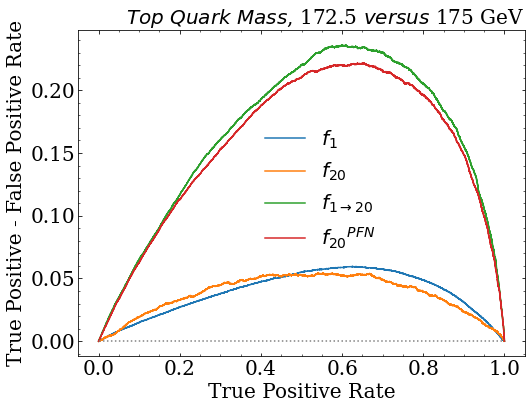

In [471]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

plt.plot(tpr_1D_top,1-fpr_1D_top-(1-tpr_1D_top),label="$f_{1}$")
plt.plot(tpr_nD_top,1-fpr_nD_top-(1-tpr_nD_top),label="$f_{"+str(n_top)+"}$")
plt.plot(tpr_nD_from1D_top,1-fpr_nD_from1D_top-(1-tpr_nD_from1D_top),label=r"$f_{1\rightarrow"+str(n_top)+"}$")
plt.plot(tpr_nD_top_pfn,1-fpr_nD_top_pfn-(1-tpr_nD_top_pfn),label="$f_{"+str(n_top)+"}$${}^{PFN}$")
plt.plot([0,1],[0,0],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=20)
plt.ylabel("True Positive - False Positive Rate",fontsize=20)
plt.legend(frameon=False,fontsize=20,loc=(0.4,0.3))

plt.title(r"$Top$ $Quark$ $Mass$, 172.5 $versus$ 175 GeV",loc="right",fontsize=20)
plt.savefig("ensembleLearnPlots/Top_ROC.pdf",bbox_inches='tight')

In [472]:
tprs_pfn = []
fprs_pfn = []
vallosses_pfn = []
trainlosses_pfn = []
if (retrain):
    Phi_sizes_top, F_sizes_top = (100, 100, 128), (100, 100, 100)
    pfn_top_1e = PFN(input_dim=X_nD_val_top_pfn.shape[-1], Phi_sizes=Phi_sizes_top, F_sizes=F_sizes_top)
    num_epoch = 100
    batch_size = 5000 #was 5000

    for i in range(num_epoch):
        print("on epoch",i)
        historyf_top_1e = pfn_top_1e.fit(X_nD_train_top_pfn, to_categorical(Y_nD_top_train,2),epochs=1,batch_size=batch_size,validation_data=(X_nD_val_top_pfn, to_categorical(Y_nD_top_val,2)),verbose=1)
        scores_nD_tops_pfn_1e = pfn_top_1e.predict(X_nD_val_top_pfn,batch_size=int(0.1*len(X_nD_top_train)))
        fpr_nD_top_pfn_1e, tpr_nD_top_pfn_1e, _ = roc_curve(Y_nD_top_val, scores_nD_tops_pfn_1e[:,1])
        tprs_pfn+=[tpr_nD_top_pfn_1e]
        fprs_pfn+=[fpr_nD_top_pfn_1e]
        vallosses_pfn+=[historyf_top_1e.history['val_loss'][0]]
        trainlosses_pfn+=[historyf_top_1e.history['loss'][0]]
        
    np.save("ensemblelearning/tprs_pfn",np.array(tprs_pfn))
    np.save("ensemblelearning/fprs_pfn",np.array(fprs_pfn))
    np.save("ensemblelearning/vallosses_pfn",np.array(vallosses_pfn))
    np.save("ensemblelearning/trainlosses_pfn",np.array(trainlosses_pfn))
    
else:
    tprs_pfn = np.load("ensemblelearning/tprs_pfn.npy",allow_pickle=True)
    fprs_pfn = np.load("ensemblelearning/fprs_pfn.npy",allow_pickle=True)
    vallosses_pfn = np.load("ensemblelearning/vallosses_pfn.npy",allow_pickle=True)
    trainlosses_pfn = np.load("ensemblelearning/trainlosses_pfn.npy",allow_pickle=True)

In [473]:
tprs = []
fprs = []
vallosses = []
trainlosses = []

if (retrain):
    model1D_top_1e = Sequential()
    model1D_top_1e.add(Dense(128, activation='relu',input_shape =(4,))) 
    model1D_top_1e.add(Dense(128, activation='relu'))
    model1D_top_1e.add(Dense(1, activation='sigmoid'))
    model1D_top_1e.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    for i in range(num_epoch):
        print("on epoch",i)

        hist_top_model1D_1e= model1D_top_1e.fit(X_1D_top_train, Y_1D_top_train, epochs=1, batch_size=int(0.1*len(X_1D_top_train)),validation_data=(X_1D_top_val, Y_1D_top_val))
        scores_1D_top_1e = model1D_top_1e.predict(X_1D_top_val,batch_size=int(0.1*len(X_1D_top_train)))

        scores_1D_fromnD_top_1e = model1D_top_1e.predict(scaler_1D_top.transform(np.reshape(scaler_top.inverse_transform(X_nD_top_val),[n_top*len(X_nD_top_val),4])),batch_size=int(0.1*len(X_nD_top_train)))
        scores_1D_fromnD_top_1e = np.reshape(scores_1D_fromnD_top_1e,[int(len(scores_1D_fromnD_top_1e)/n_top),n_top])
        scaled_up_top_1e = np.array([np.prod(scores_1D_fromnD_top_1e[i,:] / (1.-scores_1D_fromnD_top_1e[i,:])) for i in range(len(scores_1D_fromnD_top_1e))])

        fpr_nD_from1D_top_1e, tpr_nD_from1D_top_1e, _ = roc_curve(Y_nD_top_val, scaled_up_top_1e)

        tprs+=[tpr_nD_from1D_top_1e]
        fprs+=[fpr_nD_from1D_top_1e]
        vallosses+=[hist_top_model1D_1e.history['val_loss'][0]]
        trainlosses+=[hist_top_model1D_1e.history['loss'][0]]
    np.save("ensemblelearning/tprs",np.array(tprs))
    np.save("ensemblelearning/fprs",np.array(fprs))
    np.save("ensemblelearning/vallosses",np.array(vallosses))
    np.save("ensemblelearning/trainlosses",np.array(trainlosses))
    
else:
    tprs = np.load("ensemblelearning/tprs.npy",allow_pickle=True)
    fprs = np.load("ensemblelearning/fprs.npy",allow_pickle=True)
    vallosses = np.load("ensemblelearning/vallosses.npy",allow_pickle=True)
    trainlosses = np.load("ensemblelearning/trainlosses.npy",allow_pickle=True)

In [474]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx #array[idx]

In [475]:
fprat50s = [fprs[i][find_nearest(tprs[i],0.5)] for i in range(len(tprs))]
fprat50s_pfn = [fprs_pfn[i][find_nearest(tprs_pfn[i],0.5)] for i in range(len(fprs_pfn))]

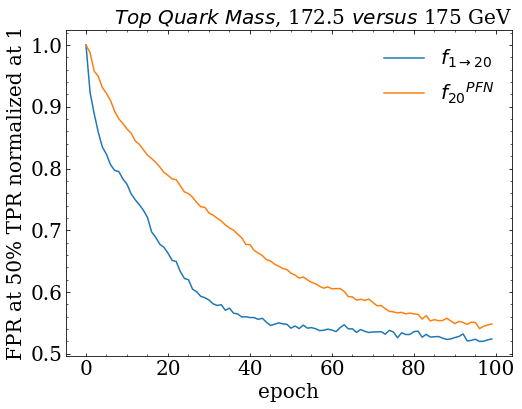

In [476]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

#plt.plot(fprat50s/fprat50s[0],label="$f_{\{20\}}$")
#plt.plot(fprat50s_pfn/fprat50s_pfn[0],label="$f_{20}$ (PFN)")

plt.plot(fprat50s/fprat50s[0],label=r"$f_{1\rightarrow 20}$")
plt.plot(fprat50s_pfn/fprat50s_pfn[0],label="$f_{20}$${}^{PFN}$")

plt.legend(frameon=False,fontsize=20)
plt.xlabel("epoch",fontsize=20)
plt.ylabel("FPR at 50% TPR normalized at 1",fontsize=20)

plt.title(r"$Top$ $Quark$ $Mass$, 172.5 $versus$ 175 GeV",loc="right",fontsize=20)
plt.savefig("ensembleLearnPlots/Top_LearningRate.pdf",bbox_inches='tight')

## Random notes below here.

In [483]:
model_BCE = Sequential()
model_BCE.add(Dense(64, activation='relu',input_shape =(1,))) 
model_BCE.add(Dense(128, activation='relu'))
model_BCE.add(Dense(64, activation='relu'))
model_BCE.add(Dense(1, activation='sigmoid'))
model_BCE.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
hist_BCE = model_BCE.fit(X_MLE_train, Y_MLE_train, epochs=40, batch_size=int(0.01*len(X_MLE_train)),validation_data=(X_MLE_val, Y_MLE_val))


Epoch 1/40
100/100 [==============================] - 0s 3ms/step - loss: 0.6556 - accuracy: 0.6127 - val_loss: 0.6526 - val_accuracy: 0.6138
Epoch 2/40
100/100 [==============================] - 0s 3ms/step - loss: 0.6518 - accuracy: 0.6159 - val_loss: 0.6523 - val_accuracy: 0.6140
Epoch 3/40
100/100 [==============================] - 0s 3ms/step - loss: 0.6518 - accuracy: 0.6164 - val_loss: 0.6522 - val_accuracy: 0.6143
Epoch 4/40
100/100 [==============================] - 0s 3ms/step - loss: 0.6518 - accuracy: 0.6161 - val_loss: 0.6530 - val_accuracy: 0.6139
Epoch 5/40
100/100 [==============================] - 0s 3ms/step - loss: 0.6518 - accuracy: 0.6158 - val_loss: 0.6524 - val_accuracy: 0.6137
Epoch 6/40
100/100 [==============================] - 0s 3ms/step - loss: 0.6518 - accuracy: 0.6170 - val_loss: 0.6521 - val_accuracy: 0.6141
Epoch 7/40
100/100 [==============================] - 0s 3ms/step - loss: 0.6519 - accuracy: 0.6161 - val_loss: 0.6521 - val_accuracy: 0.6143
Epoch 

In [484]:
model_json = model_BCE.to_json()
with open("ensemblelearning/model_BCE.json", "w") as json_file:
    json_file.write(model_json)
model_BCE.save_weights("ensemblelearning/model_BCE.h5")  

In [477]:
#MLC loss

N = 100000

theta0 = 0.2

if (retrain):
    X_MC = np.random.normal(theta0,0.5,N)
    X_data = np.random.normal(0.5,0.5,N)
    X_MLE_train, X_MLE_val, Y_MLE_train, Y_MLE_val = train_test_split(np.concatenate([X_data,X_MC]), np.concatenate([np.ones(len(X_data)),np.zeros(len(X_MC))]), test_size=0.5)
    np.save("ensemblelearning/X_MLE_train",X_MLE_train)
    np.save("ensemblelearning/X_MLE_val",X_MLE_val)
    np.save("ensemblelearning/Y_MLE_train",Y_MLE_train)
    np.save("ensemblelearning/Y_MLE_val",Y_MLE_val)
else:
    X_MLE_train = np.load("ensemblelearning/X_MLE_train.npy")
    X_MLE_val = np.load("ensemblelearning/X_MLE_val.npy")
    Y_MLE_train = np.load("ensemblelearning/Y_MLE_train.npy")
    Y_MLE_val = np.load("ensemblelearning/Y_MLE_val.npy")

def CustomLoss2(y_true, y_pred):
    return -y_true*K.log(y_pred**2+0.00000001) + (1.-y_true)*y_pred**2

def CustomLoss(y_true, y_pred):
    return -y_true*K.log(y_pred+0.00000001) + (1.-y_true)*y_pred

if (retrain):
    model_MLE2 = Sequential()
    model_MLE2.add(Dense(64, activation='relu',input_shape =(1,))) 
    model_MLE2.add(Dense(128, activation='relu'))
    model_MLE2.add(Dense(64, activation='relu'))
    model_MLE2.add(Dense(1, activation='linear')) #was sigmoid
    model_MLE2.compile(loss=lambda y_true, y_pred: CustomLoss2(y_true, y_pred), optimizer='adam', metrics=['accuracy'])
    hist_MLE2 = model_MLE2.fit(X_MLE_train, Y_MLE_train, epochs=40, batch_size=int(0.01*len(X_MLE_train)),validation_data=(X_MLE_val, Y_MLE_val))

    model_MLE = Sequential()
    model_MLE.add(Dense(64, activation='relu',input_shape =(1,))) 
    model_MLE.add(Dense(128, activation='relu'))
    model_MLE.add(Dense(64, activation='relu'))
    model_MLE.add(Dense(1, activation='relu')) #was sigmoid
    model_MLE.compile(loss=lambda y_true, y_pred: CustomLoss(y_true, y_pred), optimizer='adam', metrics=['accuracy'])
    hist_MLE = model_MLE.fit(X_MLE_train, Y_MLE_train, epochs=40, batch_size=int(0.01*len(X_MLE_train)),validation_data=(X_MLE_val, Y_MLE_val))
    
    model_json = model_MLE.to_json()
    with open("ensemblelearning/model_MLE.json", "w") as json_file:
        json_file.write(model_json)
    model_MLE.save_weights("ensemblelearning/model_MLE.h5")
    
    model_json = model_MLE2.to_json()
    with open("ensemblelearning/model_MLE2.json", "w") as json_file:
        json_file.write(model_json)
    model_MLE2.save_weights("ensemblelearning/model_MLE2.h5")    
    
else:
    json_file = open('ensemblelearning/model_MLE.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model_MLE = model_from_json(loaded_model_json)
    model_MLE.load_weights("ensemblelearning/model_MLE.h5") 
    
    json_file = open('ensemblelearning/model_MLE2.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model_MLE2 = model_from_json(loaded_model_json)
    model_MLE2.load_weights("ensemblelearning/model_MLE2.h5") 

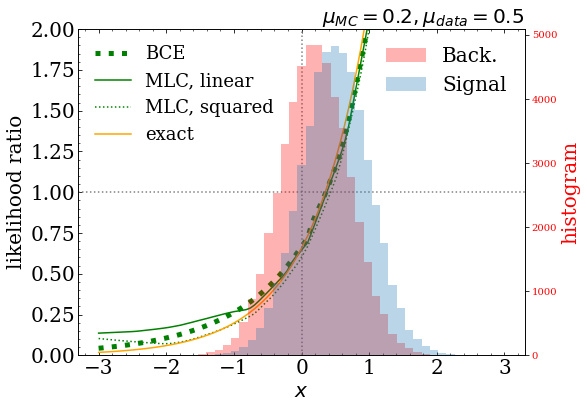

In [492]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax1 = plt.subplot(gs[0])
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax1.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax1.minorticks_on()

xx = np.linspace(-3,3,100)
preds_BCE = model_BCE.predict(xx)
plotBCE = plt.plot(xx,preds_BCE/(1.-preds_BCE),label="NN (BCE)",ls=":",lw=5,color='green')
preds_test2 = model_MLE2.predict(xx)**2
plot12 = plt.plot(xx,preds_test2,label="NN (MLC, squared)",ls=":",color='green')
preds_test = model_MLE.predict(xx)
plot11 = plt.plot(xx,preds_test,label="NN (MLC, linear)",ls="-",color='green')
plot2 = plt.plot(xx,np.exp(-((xx-0.5)**2-(xx-theta0)**2)/(2*0.5**2)),label="exact",color='orange')
plt.ylim([0,2])
plt.axvline(0,ls=":",color="grey")
plt.axhline(1,ls=":",color="grey")
plt.xlabel(r"$x$",fontsize=20)
plt.ylabel("likelihood ratio",fontsize=20)
plt.title(r"$\mu_{MC} = "+str(theta0)+r", \mu_{data}=0.5$",loc="right",fontsize=20)

ax2 = ax1.twinx()
_,_,_=plt.hist(X_MLE_train[Y_MLE_train==0],bins=np.linspace(-3,3,50),alpha=0.3,label="Back.",color='red')
_,_,_=plt.hist(X_MLE_train[Y_MLE_train==1],bins=np.linspace(-3,3,50),alpha=0.3,label="Signal")
ax2.tick_params(axis='y', labelcolor="red")
ax2.set_ylabel("histogram",color='red',fontsize=20)

for label in ax2.yaxis.get_majorticklabels():
        label.set_fontsize(50)
        label.set_fontname('verdana')

leg = plt.legend([plotBCE[0], plot11[0],plot12[0],plot2[0]],['BCE', 'MLC, linear','MLC, squared','exact'], loc="upper left",frameon=False,fontsize=18)
plt.legend(frameon=False,fontsize=20)
plt.gca().add_artist(leg)

plt.savefig("ensembleLearnPlots/MLCloss.pdf",bbox_inches='tight')

#Add in the BCE version

In [501]:
#X_MC = np.c_[MC,thetas]
#X_data = np.c_[data,thetas]

In [595]:
'''
N = 100000

term1 = []
term2 = []
for theta0 in [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.]:

    X_MC = np.random.normal(theta0,0.5,N)
    X_data = np.random.normal(0.5,0.5,N)

    X_MLE_train, X_MLE_val, Y_MLE_train, Y_MLE_val = train_test_split(np.concatenate([X_data,X_MC]), np.concatenate([np.ones(len(X_data)),np.zeros(len(X_MC))]), test_size=0.5)

    def CustomLoss(y_true, y_pred):
        return -y_true*K.log(y_pred**2+0.00000001) + (1.-y_true)*y_pred**2

    K.clear_session()
    
    model_MLE = Sequential()
    model_MLE.add(Dense(64, activation='elu',input_shape =(1,))) 
    model_MLE.add(Dense(128, activation='elu'))
    model_MLE.add(Dense(64, activation='elu'))
    model_MLE.add(Dense(1, activation='linear')) #was sigmoid
    model_MLE.compile(loss=lambda y_true, y_pred: CustomLoss(y_true, y_pred), optimizer='adam', metrics=['accuracy'])
    hist_MLE = model_MLE.fit(X_MLE_train, Y_MLE_train, epochs=20, batch_size=int(0.1*len(X_MLE_train)),validation_data=(X_MLE_val, Y_MLE_val))

    preds = model_MLE.predict(X_MLE_val)**2
    preds = -Y_MLE_val*np.log(preds[:,0]+0.00000001) + (1.-Y_MLE_val)*preds[:,0]
    print(theta0,np.mean(preds[Y_MLE_val==1]),np.mean(preds[Y_MLE_val==0]))
    term1+=[np.mean(preds[Y_MLE_val==1])]
    term2+=[np.mean(preds[Y_MLE_val==0])]
'''

Train on 100000 samples, validate on 100000 samples
Epoch 1/20
100000/100000 [==============================] - 1s 5us/step - loss: 1.0489 - acc: 0.4680 - val_loss: 0.7685 - val_acc: 0.2978
Epoch 2/20
100000/100000 [==============================] - 0s 1us/step - loss: 0.7907 - acc: 0.2797 - val_loss: 0.7110 - val_acc: 0.3148
Epoch 3/20
100000/100000 [==============================] - 0s 1us/step - loss: 0.6579 - acc: 0.3891 - val_loss: 0.6314 - val_acc: 0.4673
Epoch 4/20
100000/100000 [==============================] - 0s 1us/step - loss: 0.6050 - acc: 0.4865 - val_loss: 0.5696 - val_acc: 0.4685
Epoch 5/20
100000/100000 [==============================] - 0s 1us/step - loss: 0.5374 - acc: 0.4467 - val_loss: 0.5191 - val_acc: 0.4165
Epoch 6/20
100000/100000 [==============================] - 0s 1us/step - loss: 0.4999 - acc: 0.4268 - val_loss: 0.4710 - val_acc: 0.4619
Epoch 7/20
100000/100000 [==============================] - 0s 1us/step - loss: 0.4599 - acc: 0.4736 - val_loss: 0.4585 

100000/100000 [==============================] - 0s 1us/step - loss: 0.4700 - acc: 0.5085 - val_loss: 0.4688 - val_acc: 0.5079
Epoch 15/20
100000/100000 [==============================] - 0s 1us/step - loss: 0.4685 - acc: 0.5070 - val_loss: 0.4678 - val_acc: 0.5086
Epoch 16/20
100000/100000 [==============================] - 0s 1us/step - loss: 0.4676 - acc: 0.5059 - val_loss: 0.4669 - val_acc: 0.5074
Epoch 17/20
100000/100000 [==============================] - 0s 1us/step - loss: 0.4669 - acc: 0.5058 - val_loss: 0.4661 - val_acc: 0.5060
Epoch 18/20
100000/100000 [==============================] - 0s 1us/step - loss: 0.4662 - acc: 0.5055 - val_loss: 0.4654 - val_acc: 0.5066
Epoch 19/20
100000/100000 [==============================] - 0s 1us/step - loss: 0.4656 - acc: 0.5041 - val_loss: 0.4649 - val_acc: 0.5071
Epoch 20/20
100000/100000 [==============================] - 0s 1us/step - loss: 0.4652 - acc: 0.5049 - val_loss: 0.4642 - val_acc: 0.5052
0.7 -0.08068898214116356 1.010673223987

100000/100000 [==============================] - 0s 1us/step - loss: 0.2753 - acc: 0.4047 - val_loss: 0.2860 - val_acc: 0.4257
Epoch 12/20
100000/100000 [==============================] - 0s 1us/step - loss: 0.2767 - acc: 0.3606 - val_loss: 0.2761 - val_acc: 0.3808
Epoch 13/20
100000/100000 [==============================] - 0s 1us/step - loss: 0.3013 - acc: 0.3608 - val_loss: 0.3709 - val_acc: 0.2383
Epoch 14/20
100000/100000 [==============================] - 0s 1us/step - loss: 0.2986 - acc: 0.4074 - val_loss: 0.2771 - val_acc: 0.4127
Epoch 15/20
100000/100000 [==============================] - 0s 1us/step - loss: 0.2771 - acc: 0.3881 - val_loss: 0.2855 - val_acc: 0.4656
Epoch 16/20
100000/100000 [==============================] - 0s 1us/step - loss: 0.2740 - acc: 0.4207 - val_loss: 0.2760 - val_acc: 0.3512
Epoch 17/20
100000/100000 [==============================] - 0s 1us/step - loss: 0.2957 - acc: 0.4233 - val_loss: 0.3182 - val_acc: 0.4537
Epoch 18/20
100000/100000 [============

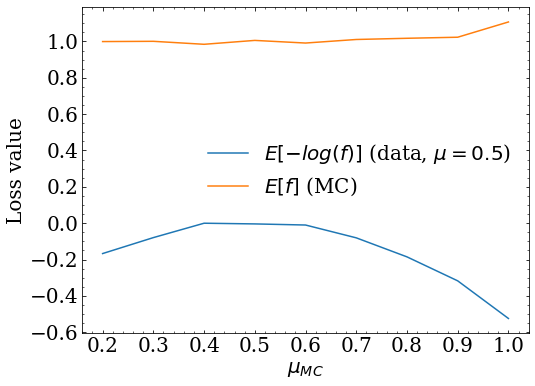

In [596]:
'''
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

plt.plot([0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.],term1,label="$E[-log(f)]$ (data, $\mu=0.5$)")
plt.plot([0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.],term2,label="$E[f]$ (MC)")
plt.xlabel("$\mu_{MC}$",fontsize=20)
plt.ylabel("Loss value",fontsize=20)
plt.legend(frameon=False,fontsize=20)
'''

In [572]:
#K.clear_session()

In [624]:
'''
def CustomLoss(y_true, y_pred):
    #y_pred[:,0] is the NN output, should approach the LLR.
    #y_pred[:,1] is the mean of the prior p(\theta)
    #y_pred[:,2] is the sigma of the prior p(\theta)

    #y_true[:,0] is 0 or 1
    #y_true[:,1] is theta
    #myweight = (sigma0/y_pred[:,2])*K.exp(-(y_true[:,1]-y_pred[:,1])**2/(2.*y_pred[:,2]**2)+(y_true[:,1]-theta0)**2/(2*sigma0**2))
    return (-y_true[:,0]*K.log(y_pred[:,0]**2+0.00000001) + (1.-y_true[:,0])*y_pred[:,0]**2) #*myweight
    #return -y_true*K.log(K.exp(y_pred)) + (1.-y_true)*K.exp(y_pred)
        
N = 200000

theta0 = 0.4
sigma0 = 0.2

X_data = np.random.normal(0.5,0.5,N)

sigmaval = []
meanval = []
lossval1 = []
lossval2 = []

for theta0 in np.linspace(0.2,1.,10):
    holdsig1 = []
    holdsig2 = []
    for sigma0 in np.linspace(0.01,0.2,10):

        thetas = np.random.normal(theta0,sigma0,N)

        X_MC = np.random.normal(thetas,0.5,N)

        Y_MC = np.zeros(len(X_MC)) #np.c_[np.zeros(len(X_MC)),thetas]
        Y_data = np.ones(len(X_data)) #np.c_[np.ones(len(X_data)),thetas]

        X_MLE_train, X_MLE_val, Y_MLE_train, Y_MLE_val = train_test_split(np.concatenate([X_data,X_MC]), np.concatenate([Y_data,Y_MC]), test_size=0.5)

        K.clear_session()

        model_MLE = Sequential()
        model_MLE.add(Dense(64, activation='elu',input_shape =(1,))) 
        model_MLE.add(Dense(128, activation='elu'))
        model_MLE.add(Dense(64, activation='elu'))
        model_MLE.add(Dense(1, activation='linear')) #was sigmoid
        model_MLE.compile(loss=lambda y_true, y_pred: CustomLoss(y_true, y_pred), optimizer='adam', metrics=['accuracy'])
        hist_MLE = model_MLE.fit(X_MLE_train, Y_MLE_train, epochs=50, batch_size=int(0.1*len(X_MLE_train)),validation_data=(X_MLE_val, Y_MLE_val))

        preds = model_MLE.predict(X_MLE_val)**2
        preds = -Y_MLE_val*np.log(preds[:,0]+0.00000001) + (1.-Y_MLE_val)*preds[:,0]

        holdsig1+=[np.mean(preds[Y_MLE_val==1])]
        holdsig2+=[np.mean(preds[Y_MLE_val==0])]
    lossval1+=[holdsig1]
    lossval2+=[holdsig2]
'''

Train on 200000 samples, validate on 200000 samples
Epoch 1/50
200000/200000 [==============================] - 0s 2us/step - loss: 1.6882 - acc: 0.3783 - val_loss: 0.7517 - val_acc: 0.2415
Epoch 2/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.6947 - acc: 0.2113 - val_loss: 0.6722 - val_acc: 0.1865
Epoch 3/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.6754 - acc: 0.1793 - val_loss: 0.6809 - val_acc: 0.1718
Epoch 4/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.6799 - acc: 0.1710 - val_loss: 0.6769 - val_acc: 0.1693
Epoch 5/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.6713 - acc: 0.1713 - val_loss: 0.6649 - val_acc: 0.1722
Epoch 6/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.6614 - acc: 0.1755 - val_loss: 0.6557 - val_acc: 0.1767
Epoch 7/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.6533 - acc: 0.1793 - val_loss: 0.6485 

Epoch 18/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4196 - acc: 0.4928 - val_loss: 0.4187 - val_acc: 0.4934
Epoch 19/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4192 - acc: 0.4930 - val_loss: 0.4184 - val_acc: 0.4932
Epoch 20/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4189 - acc: 0.4910 - val_loss: 0.4181 - val_acc: 0.4909
Epoch 21/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4187 - acc: 0.4917 - val_loss: 0.4178 - val_acc: 0.4896
Epoch 22/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4184 - acc: 0.4863 - val_loss: 0.4176 - val_acc: 0.4862
Epoch 23/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4181 - acc: 0.4867 - val_loss: 0.4172 - val_acc: 0.4878
Epoch 24/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4179 - acc: 0.4860 - val_loss: 0.4170 - val_acc: 0.4862
Epoch 25/50
200000/200000 [

Epoch 35/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4157 - acc: 0.4682 - val_loss: 0.4160 - val_acc: 0.4702
Epoch 36/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4155 - acc: 0.4733 - val_loss: 0.4158 - val_acc: 0.4696
Epoch 37/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4154 - acc: 0.4675 - val_loss: 0.4157 - val_acc: 0.4693
Epoch 38/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4153 - acc: 0.4704 - val_loss: 0.4156 - val_acc: 0.4671
Epoch 39/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4152 - acc: 0.4673 - val_loss: 0.4156 - val_acc: 0.4671
Epoch 40/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4151 - acc: 0.4670 - val_loss: 0.4155 - val_acc: 0.4648
Epoch 41/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4150 - acc: 0.4651 - val_loss: 0.4154 - val_acc: 0.4647
Epoch 42/50
200000/200000 [

200000/200000 [==============================] - 0s 2us/step - loss: 1.2534 - acc: 0.3327 - val_loss: 0.6720 - val_acc: 0.1799
Epoch 2/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.7131 - acc: 0.1532 - val_loss: 0.7520 - val_acc: 0.1382
Epoch 3/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.6918 - acc: 0.1395 - val_loss: 0.6164 - val_acc: 0.1446
Epoch 4/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.5837 - acc: 0.1518 - val_loss: 0.5595 - val_acc: 0.1583
Epoch 5/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.5474 - acc: 0.1552 - val_loss: 0.5231 - val_acc: 0.1453
Epoch 6/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4869 - acc: 0.1217 - val_loss: 0.4475 - val_acc: 0.0881
Epoch 7/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4296 - acc: 0.0613 - val_loss: 0.4218 - val_acc: 0.0301
Epoch 8/50
200000/200000 [===================

Epoch 10/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4230 - acc: 0.0296 - val_loss: 0.4224 - val_acc: 0.0377
Epoch 11/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4280 - acc: 0.0537 - val_loss: 0.4419 - val_acc: 0.0706
Epoch 12/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4327 - acc: 0.0627 - val_loss: 0.4289 - val_acc: 0.0359
Epoch 13/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4264 - acc: 0.0258 - val_loss: 0.4231 - val_acc: 0.0259
Epoch 14/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4240 - acc: 0.0288 - val_loss: 0.4214 - val_acc: 0.0292
Epoch 15/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4211 - acc: 0.0347 - val_loss: 0.4215 - val_acc: 0.0399
Epoch 16/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4212 - acc: 0.0414 - val_loss: 0.4220 - val_acc: 0.0433
Epoch 17/50
200000/200000 [

Epoch 27/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4618 - acc: 0.5076 - val_loss: 0.4615 - val_acc: 0.5076
Epoch 28/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4616 - acc: 0.5076 - val_loss: 0.4613 - val_acc: 0.5076
Epoch 29/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4615 - acc: 0.5076 - val_loss: 0.4611 - val_acc: 0.5075
Epoch 30/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4613 - acc: 0.5075 - val_loss: 0.4610 - val_acc: 0.5075
Epoch 31/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4612 - acc: 0.5074 - val_loss: 0.4608 - val_acc: 0.5074
Epoch 32/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4611 - acc: 0.5074 - val_loss: 0.4607 - val_acc: 0.5075
Epoch 33/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4610 - acc: 0.5074 - val_loss: 0.4606 - val_acc: 0.5072
Epoch 34/50
200000/200000 [

Epoch 44/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4572 - acc: 0.4874 - val_loss: 0.4563 - val_acc: 0.4881
Epoch 45/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4571 - acc: 0.4854 - val_loss: 0.4563 - val_acc: 0.4860
Epoch 46/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4571 - acc: 0.4859 - val_loss: 0.4563 - val_acc: 0.4872
Epoch 47/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4571 - acc: 0.4856 - val_loss: 0.4562 - val_acc: 0.4863
Epoch 48/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4571 - acc: 0.4847 - val_loss: 0.4562 - val_acc: 0.4860
Epoch 49/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4571 - acc: 0.4848 - val_loss: 0.4562 - val_acc: 0.4855
Epoch 50/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4571 - acc: 0.4845 - val_loss: 0.4562 - val_acc: 0.4858
Train on 200000 samples, va

Epoch 11/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4616 - acc: 0.5110 - val_loss: 0.4607 - val_acc: 0.5087
Epoch 12/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4609 - acc: 0.5086 - val_loss: 0.4606 - val_acc: 0.5071
Epoch 13/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4608 - acc: 0.5072 - val_loss: 0.4604 - val_acc: 0.5065
Epoch 14/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4607 - acc: 0.5073 - val_loss: 0.4602 - val_acc: 0.5068
Epoch 15/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4605 - acc: 0.5073 - val_loss: 0.4601 - val_acc: 0.5065
Epoch 16/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4604 - acc: 0.5069 - val_loss: 0.4599 - val_acc: 0.5061
Epoch 17/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4602 - acc: 0.5065 - val_loss: 0.4598 - val_acc: 0.5055
Epoch 18/50
200000/200000 [

Epoch 28/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4600 - acc: 0.0093 - val_loss: 0.4581 - val_acc: 0.0093
Epoch 29/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4600 - acc: 0.0094 - val_loss: 0.4581 - val_acc: 0.0091
Epoch 30/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4600 - acc: 0.0093 - val_loss: 0.4581 - val_acc: 0.0089
Epoch 31/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4600 - acc: 0.0087 - val_loss: 0.4581 - val_acc: 0.0088
Epoch 32/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4600 - acc: 0.0088 - val_loss: 0.4580 - val_acc: 0.0085
Epoch 33/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4599 - acc: 0.0084 - val_loss: 0.4580 - val_acc: 0.0083
Epoch 34/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4599 - acc: 0.0083 - val_loss: 0.4580 - val_acc: 0.0084
Epoch 35/50
200000/200000 [

Epoch 45/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4582 - acc: 0.5060 - val_loss: 0.4589 - val_acc: 0.5064
Epoch 46/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4581 - acc: 0.5060 - val_loss: 0.4589 - val_acc: 0.5060
Epoch 47/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4581 - acc: 0.5061 - val_loss: 0.4589 - val_acc: 0.5063
Epoch 48/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4582 - acc: 0.5056 - val_loss: 0.4589 - val_acc: 0.5061
Epoch 49/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4582 - acc: 0.5058 - val_loss: 0.4589 - val_acc: 0.5063
Epoch 50/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4582 - acc: 0.5058 - val_loss: 0.4589 - val_acc: 0.5055
Train on 200000 samples, validate on 200000 samples
Epoch 1/50
200000/200000 [==============================] - 0s 2us/step - loss: 1.0699 - acc: 0.2407 - val_loss: 0

200000/200000 [==============================] - 0s 2us/step - loss: 1.0848 - acc: 0.4451 - val_loss: 0.9622 - val_acc: 0.2981
Epoch 2/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.9181 - acc: 0.3223 - val_loss: 0.8339 - val_acc: 0.4012
Epoch 3/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.8412 - acc: 0.4571 - val_loss: 0.8373 - val_acc: 0.4750
Epoch 4/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.8110 - acc: 0.4446 - val_loss: 0.7951 - val_acc: 0.4047
Epoch 5/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.7872 - acc: 0.4085 - val_loss: 0.7682 - val_acc: 0.4360
Epoch 6/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.7539 - acc: 0.4632 - val_loss: 0.7362 - val_acc: 0.4702
Epoch 7/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.7125 - acc: 0.4762 - val_loss: 0.6763 - val_acc: 0.5072
Epoch 8/50
200000/200000 [===================

Epoch 10/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.8432 - acc: 0.4139 - val_loss: 0.8356 - val_acc: 0.4104
Epoch 11/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.8283 - acc: 0.4106 - val_loss: 0.8161 - val_acc: 0.4131
Epoch 12/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.8122 - acc: 0.4182 - val_loss: 0.7985 - val_acc: 0.4260
Epoch 13/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.7939 - acc: 0.4296 - val_loss: 0.7783 - val_acc: 0.4343
Epoch 14/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.7756 - acc: 0.4331 - val_loss: 0.7611 - val_acc: 0.4426
Epoch 15/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.7506 - acc: 0.4615 - val_loss: 0.7298 - val_acc: 0.4777
Epoch 16/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.7209 - acc: 0.4866 - val_loss: 0.7078 - val_acc: 0.4955
Epoch 17/50
200000/200000 [

200000/200000 [==============================] - 0s 1us/step - loss: 0.4858 - acc: 0.0011 - val_loss: 0.4869 - val_acc: 9.7000e-04
Epoch 27/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4858 - acc: 0.0010 - val_loss: 0.4869 - val_acc: 9.0500e-04
Epoch 28/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4858 - acc: 9.9000e-04 - val_loss: 0.4869 - val_acc: 9.5500e-04
Epoch 29/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4858 - acc: 0.0010 - val_loss: 0.4869 - val_acc: 9.2000e-04
Epoch 30/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4858 - acc: 9.8000e-04 - val_loss: 0.4869 - val_acc: 9.0500e-04
Epoch 31/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4858 - acc: 9.5000e-04 - val_loss: 0.4868 - val_acc: 8.7000e-04
Epoch 32/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4857 - acc: 9.5000e-04 - val_loss: 0.4868 - val_acc: 8.6000

Epoch 33/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4854 - acc: 5.4000e-04 - val_loss: 0.4872 - val_acc: 5.7500e-04
Epoch 34/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4854 - acc: 4.6500e-04 - val_loss: 0.4871 - val_acc: 5.4500e-04
Epoch 35/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4854 - acc: 4.2500e-04 - val_loss: 0.4871 - val_acc: 4.1500e-04
Epoch 36/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4853 - acc: 2.3500e-04 - val_loss: 0.4871 - val_acc: 4.2500e-04
Epoch 37/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4853 - acc: 3.2500e-04 - val_loss: 0.4870 - val_acc: 3.6500e-04
Epoch 38/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4853 - acc: 2.2500e-04 - val_loss: 0.4871 - val_acc: 4.0000e-04
Epoch 39/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4853 - acc: 2.6000e-04 - val_loss: 

Epoch 39/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4858 - acc: 5.8000e-04 - val_loss: 0.4848 - val_acc: 5.4500e-04
Epoch 40/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4858 - acc: 5.4500e-04 - val_loss: 0.4848 - val_acc: 5.0500e-04
Epoch 41/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4858 - acc: 5.4500e-04 - val_loss: 0.4848 - val_acc: 5.3500e-04
Epoch 42/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4859 - acc: 5.9500e-04 - val_loss: 0.4848 - val_acc: 5.7000e-04
Epoch 43/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4858 - acc: 5.5500e-04 - val_loss: 0.4848 - val_acc: 4.8500e-04
Epoch 44/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4858 - acc: 5.5000e-04 - val_loss: 0.4848 - val_acc: 5.4500e-04
Epoch 45/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4858 - acc: 5.6000e-04 - val_loss: 

Epoch 47/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4866 - acc: 0.4991 - val_loss: 0.4847 - val_acc: 0.5023
Epoch 48/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4866 - acc: 0.4991 - val_loss: 0.4847 - val_acc: 0.5021
Epoch 49/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4866 - acc: 0.4991 - val_loss: 0.4847 - val_acc: 0.5022
Epoch 50/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4866 - acc: 0.4991 - val_loss: 0.4847 - val_acc: 0.5022
Train on 200000 samples, validate on 200000 samples
Epoch 1/50
200000/200000 [==============================] - 0s 2us/step - loss: 1.1161 - acc: 0.4248 - val_loss: 1.0299 - val_acc: 0.2870
Epoch 2/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.9280 - acc: 0.3342 - val_loss: 0.8044 - val_acc: 0.4418
Epoch 3/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.7696 - acc: 0.5110 - val_loss: 0.6

200000/200000 [==============================] - 0s 1us/step - loss: 0.5049 - acc: 0.0013 - val_loss: 0.5042 - val_acc: 9.5500e-04
Epoch 14/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.5038 - acc: 5.9500e-04 - val_loss: 0.5034 - val_acc: 5.4000e-04
Epoch 15/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.5032 - acc: 3.9500e-04 - val_loss: 0.5030 - val_acc: 2.9000e-04
Epoch 16/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.5028 - acc: 2.8000e-04 - val_loss: 0.5025 - val_acc: 3.2000e-04
Epoch 17/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.5023 - acc: 2.7000e-04 - val_loss: 0.5021 - val_acc: 1.7000e-04
Epoch 18/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.5019 - acc: 1.8000e-04 - val_loss: 0.5017 - val_acc: 1.5500e-04
Epoch 19/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.5017 - acc: 1.0000e-04 - val_loss: 0.5014 - val_acc

200000/200000 [==============================] - 0s 1us/step - loss: 0.5002 - acc: 0.0000e+00 - val_loss: 0.4987 - val_acc: 0.0000e+00
Epoch 20/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.5001 - acc: 0.0000e+00 - val_loss: 0.4987 - val_acc: 0.0000e+00
Epoch 21/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.5001 - acc: 0.0000e+00 - val_loss: 0.4987 - val_acc: 0.0000e+00
Epoch 22/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.5001 - acc: 0.0000e+00 - val_loss: 0.4987 - val_acc: 0.0000e+00
Epoch 23/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.5001 - acc: 0.0000e+00 - val_loss: 0.4987 - val_acc: 0.0000e+00
Epoch 24/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.5001 - acc: 0.0000e+00 - val_loss: 0.4986 - val_acc: 0.0000e+00
Epoch 25/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.5001 - acc: 0.0000e+00 - val_loss: 0.4986 - val

Epoch 25/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4996 - acc: 0.0000e+00 - val_loss: 0.4992 - val_acc: 0.0000e+00
Epoch 26/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4996 - acc: 0.0000e+00 - val_loss: 0.4992 - val_acc: 0.0000e+00
Epoch 27/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4996 - acc: 0.0000e+00 - val_loss: 0.4992 - val_acc: 0.0000e+00
Epoch 28/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4995 - acc: 0.0000e+00 - val_loss: 0.4992 - val_acc: 0.0000e+00
Epoch 29/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4995 - acc: 0.0000e+00 - val_loss: 0.4991 - val_acc: 0.0000e+00
Epoch 30/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4995 - acc: 0.0000e+00 - val_loss: 0.4991 - val_acc: 0.0000e+00
Epoch 31/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4995 - acc: 0.0000e+00 - val_loss: 

Epoch 41/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4988 - acc: 0.5009 - val_loss: 0.5006 - val_acc: 0.4991
Epoch 42/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4987 - acc: 0.5009 - val_loss: 0.5006 - val_acc: 0.4991
Epoch 43/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4987 - acc: 0.5009 - val_loss: 0.5006 - val_acc: 0.4991
Epoch 44/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4987 - acc: 0.5009 - val_loss: 0.5006 - val_acc: 0.4991
Epoch 45/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4987 - acc: 0.5009 - val_loss: 0.5006 - val_acc: 0.4991
Epoch 46/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4987 - acc: 0.5009 - val_loss: 0.5006 - val_acc: 0.4991
Epoch 47/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4987 - acc: 0.5009 - val_loss: 0.5006 - val_acc: 0.4991
Epoch 48/50
200000/200000 [

200000/200000 [==============================] - 0s 1us/step - loss: 0.8067 - acc: 0.1191 - val_loss: 0.7608 - val_acc: 0.1063
Epoch 6/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.6901 - acc: 0.0858 - val_loss: 0.5926 - val_acc: 0.0471
Epoch 7/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.5358 - acc: 0.0182 - val_loss: 0.5009 - val_acc: 0.0019
Epoch 8/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.5060 - acc: 5.5500e-04 - val_loss: 0.5090 - val_acc: 8.5000e-05
Epoch 9/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.5078 - acc: 1.0500e-04 - val_loss: 0.5019 - val_acc: 1.0500e-04
Epoch 10/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.5008 - acc: 4.0500e-04 - val_loss: 0.4989 - val_acc: 6.9500e-04
Epoch 11/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4996 - acc: 0.0010 - val_loss: 0.4992 - val_acc: 0.0012
Epoch 12/50
200000/

200000/200000 [==============================] - 0s 1us/step - loss: 0.4963 - acc: 8.5000e-05 - val_loss: 0.4976 - val_acc: 5.5000e-05
Epoch 18/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4963 - acc: 8.5000e-05 - val_loss: 0.4975 - val_acc: 7.0000e-05
Epoch 19/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4963 - acc: 1.0000e-04 - val_loss: 0.4976 - val_acc: 5.5000e-05
Epoch 20/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4963 - acc: 9.0000e-05 - val_loss: 0.4976 - val_acc: 7.5000e-05
Epoch 21/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4963 - acc: 1.2000e-04 - val_loss: 0.4975 - val_acc: 7.5000e-05
Epoch 22/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4963 - acc: 1.0500e-04 - val_loss: 0.4975 - val_acc: 7.5000e-05
Epoch 23/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4963 - acc: 1.3000e-04 - val_loss: 0.4975 - val

Epoch 24/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4972 - acc: 0.5000 - val_loss: 0.4972 - val_acc: 0.5000
Epoch 25/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4972 - acc: 0.5000 - val_loss: 0.4972 - val_acc: 0.5000
Epoch 26/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4972 - acc: 0.5000 - val_loss: 0.4972 - val_acc: 0.5000
Epoch 27/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4972 - acc: 0.5000 - val_loss: 0.4972 - val_acc: 0.5000
Epoch 28/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4972 - acc: 0.5000 - val_loss: 0.4972 - val_acc: 0.5000
Epoch 29/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4972 - acc: 0.5000 - val_loss: 0.4972 - val_acc: 0.5000
Epoch 30/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4972 - acc: 0.5000 - val_loss: 0.4972 - val_acc: 0.5000
Epoch 31/50
200000/200000 [

200000/200000 [==============================] - 0s 1us/step - loss: 0.4973 - acc: 0.0000e+00 - val_loss: 0.4974 - val_acc: 0.0000e+00
Epoch 38/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4972 - acc: 0.0000e+00 - val_loss: 0.4974 - val_acc: 0.0000e+00
Epoch 39/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4972 - acc: 0.0000e+00 - val_loss: 0.4974 - val_acc: 0.0000e+00
Epoch 40/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4972 - acc: 0.0000e+00 - val_loss: 0.4973 - val_acc: 0.0000e+00
Epoch 41/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4972 - acc: 0.0000e+00 - val_loss: 0.4973 - val_acc: 0.0000e+00
Epoch 42/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4972 - acc: 0.0000e+00 - val_loss: 0.4973 - val_acc: 0.0000e+00
Epoch 43/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4972 - acc: 0.0000e+00 - val_loss: 0.4973 - val

Epoch 45/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4970 - acc: 0.5003 - val_loss: 0.4974 - val_acc: 0.4997
Epoch 46/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4969 - acc: 0.5003 - val_loss: 0.4975 - val_acc: 0.4997
Epoch 47/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4968 - acc: 0.5003 - val_loss: 0.4976 - val_acc: 0.4997
Epoch 48/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4970 - acc: 0.5003 - val_loss: 0.4974 - val_acc: 0.4997
Epoch 49/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4969 - acc: 0.5003 - val_loss: 0.4974 - val_acc: 0.4997
Epoch 50/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4969 - acc: 0.5003 - val_loss: 0.4975 - val_acc: 0.4997
Train on 200000 samples, validate on 200000 samples
Epoch 1/50
200000/200000 [==============================] - 0s 2us/step - loss: 1.1947 - acc: 0.2039 - val_loss: 1

200000/200000 [==============================] - 0s 2us/step - loss: 2.1798 - acc: 0.3936 - val_loss: 1.1834 - val_acc: 0.2462
Epoch 2/50
200000/200000 [==============================] - 0s 1us/step - loss: 1.0932 - acc: 0.2059 - val_loss: 1.0525 - val_acc: 0.1757
Epoch 3/50
200000/200000 [==============================] - 0s 1us/step - loss: 1.0518 - acc: 0.1637 - val_loss: 1.0634 - val_acc: 0.1560
Epoch 4/50
200000/200000 [==============================] - 0s 1us/step - loss: 1.0589 - acc: 0.1539 - val_loss: 1.0617 - val_acc: 0.1533
Epoch 5/50
200000/200000 [==============================] - 0s 1us/step - loss: 1.0495 - acc: 0.1531 - val_loss: 1.0467 - val_acc: 0.1554
Epoch 6/50
200000/200000 [==============================] - 0s 1us/step - loss: 1.0345 - acc: 0.1565 - val_loss: 1.0323 - val_acc: 0.1585
Epoch 7/50
200000/200000 [==============================] - 0s 1us/step - loss: 1.0231 - acc: 0.1577 - val_loss: 1.0179 - val_acc: 0.1570
Epoch 8/50
200000/200000 [===================

Epoch 17/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4954 - acc: 0.5014 - val_loss: 0.4981 - val_acc: 0.4986
Epoch 18/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4953 - acc: 0.5014 - val_loss: 0.4981 - val_acc: 0.4986
Epoch 19/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4953 - acc: 0.5014 - val_loss: 0.4980 - val_acc: 0.4986
Epoch 20/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4953 - acc: 0.5014 - val_loss: 0.4981 - val_acc: 0.4986
Epoch 21/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4953 - acc: 0.5014 - val_loss: 0.4980 - val_acc: 0.4986
Epoch 22/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4953 - acc: 0.5014 - val_loss: 0.4980 - val_acc: 0.4986
Epoch 23/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4953 - acc: 0.5014 - val_loss: 0.4980 - val_acc: 0.4986
Epoch 24/50
200000/200000 [

200000/200000 [==============================] - 0s 1us/step - loss: 0.4948 - acc: 1.0000e-05 - val_loss: 0.4945 - val_acc: 0.0000e+00
Epoch 31/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4948 - acc: 5.0000e-06 - val_loss: 0.4945 - val_acc: 0.0000e+00
Epoch 32/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4948 - acc: 1.0000e-05 - val_loss: 0.4945 - val_acc: 0.0000e+00
Epoch 33/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4948 - acc: 1.0000e-05 - val_loss: 0.4945 - val_acc: 0.0000e+00
Epoch 34/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4948 - acc: 5.0000e-06 - val_loss: 0.4945 - val_acc: 0.0000e+00
Epoch 35/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4948 - acc: 1.0000e-05 - val_loss: 0.4945 - val_acc: 0.0000e+00
Epoch 36/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4948 - acc: 1.0000e-05 - val_loss: 0.4945 - val

Epoch 36/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4815 - acc: 0.0000e+00 - val_loss: 0.4777 - val_acc: 0.0000e+00
Epoch 37/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4814 - acc: 0.0000e+00 - val_loss: 0.4774 - val_acc: 0.0000e+00
Epoch 38/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4814 - acc: 0.0000e+00 - val_loss: 0.4774 - val_acc: 0.0000e+00
Epoch 39/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4814 - acc: 0.0000e+00 - val_loss: 0.4774 - val_acc: 0.0000e+00
Epoch 40/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4814 - acc: 0.0000e+00 - val_loss: 0.4774 - val_acc: 0.0000e+00
Epoch 41/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4813 - acc: 0.0000e+00 - val_loss: 0.4773 - val_acc: 0.0000e+00
Epoch 42/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4814 - acc: 0.0000e+00 - val_loss: 

Epoch 44/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4796 - acc: 0.4997 - val_loss: 0.4788 - val_acc: 0.5003
Epoch 45/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4796 - acc: 0.4997 - val_loss: 0.4788 - val_acc: 0.5003
Epoch 46/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4797 - acc: 0.4997 - val_loss: 0.4788 - val_acc: 0.5003
Epoch 47/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4796 - acc: 0.4997 - val_loss: 0.4788 - val_acc: 0.5003
Epoch 48/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4797 - acc: 0.4997 - val_loss: 0.4788 - val_acc: 0.5003
Epoch 49/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4796 - acc: 0.4997 - val_loss: 0.4788 - val_acc: 0.5003
Epoch 50/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4797 - acc: 0.4997 - val_loss: 0.4791 - val_acc: 0.5003
Train on 200000 samples, va

Epoch 11/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4833 - acc: 0.4992 - val_loss: 0.4785 - val_acc: 0.5028
Epoch 12/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4827 - acc: 0.4985 - val_loss: 0.4785 - val_acc: 0.5024
Epoch 13/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4826 - acc: 0.4985 - val_loss: 0.4785 - val_acc: 0.5024
Epoch 14/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4825 - acc: 0.4984 - val_loss: 0.4783 - val_acc: 0.5024
Epoch 15/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4825 - acc: 0.4984 - val_loss: 0.4784 - val_acc: 0.5025
Epoch 16/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4824 - acc: 0.4985 - val_loss: 0.4781 - val_acc: 0.5023
Epoch 17/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4824 - acc: 0.4984 - val_loss: 0.4782 - val_acc: 0.5024
Epoch 18/50
200000/200000 [

200000/200000 [==============================] - 0s 1us/step - loss: 0.4805 - acc: 4.4000e-04 - val_loss: 0.4796 - val_acc: 4.4000e-04
Epoch 20/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4805 - acc: 4.2500e-04 - val_loss: 0.4796 - val_acc: 3.4000e-04
Epoch 21/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4804 - acc: 4.0000e-04 - val_loss: 0.4796 - val_acc: 3.1000e-04
Epoch 22/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4804 - acc: 4.0500e-04 - val_loss: 0.4796 - val_acc: 2.2000e-04
Epoch 23/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4804 - acc: 2.4500e-04 - val_loss: 0.4800 - val_acc: 7.3000e-04
Epoch 24/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4806 - acc: 3.2500e-04 - val_loss: 0.4795 - val_acc: 1.8000e-04
Epoch 25/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4804 - acc: 3.5000e-04 - val_loss: 0.4795 - val

Epoch 26/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4804 - acc: 0.5001 - val_loss: 0.4789 - val_acc: 0.5004
Epoch 27/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4804 - acc: 0.5001 - val_loss: 0.4789 - val_acc: 0.5003
Epoch 28/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4804 - acc: 0.5000 - val_loss: 0.4789 - val_acc: 0.5003
Epoch 29/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4804 - acc: 0.5000 - val_loss: 0.4789 - val_acc: 0.5004
Epoch 30/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4804 - acc: 0.5001 - val_loss: 0.4790 - val_acc: 0.5003
Epoch 31/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4804 - acc: 0.5001 - val_loss: 0.4790 - val_acc: 0.5003
Epoch 32/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4804 - acc: 0.5000 - val_loss: 0.4789 - val_acc: 0.5004
Epoch 33/50
200000/200000 [

200000/200000 [==============================] - 0s 1us/step - loss: 0.4803 - acc: 0.5002 - val_loss: 0.4804 - val_acc: 0.5013
Epoch 41/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4805 - acc: 0.5004 - val_loss: 0.4804 - val_acc: 0.5012
Epoch 42/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4804 - acc: 0.5002 - val_loss: 0.4801 - val_acc: 0.5009
Epoch 43/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4803 - acc: 0.5003 - val_loss: 0.4803 - val_acc: 0.5007
Epoch 44/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4804 - acc: 0.5002 - val_loss: 0.4802 - val_acc: 0.5007
Epoch 45/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4804 - acc: 0.5003 - val_loss: 0.4803 - val_acc: 0.5007
Epoch 46/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4804 - acc: 0.5003 - val_loss: 0.4801 - val_acc: 0.5008
Epoch 47/50
200000/200000 [============

200000/200000 [==============================] - 0s 1us/step - loss: 0.9524 - acc: 0.0823 - val_loss: 0.8775 - val_acc: 0.0642
Epoch 6/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.8185 - acc: 0.0466 - val_loss: 0.7483 - val_acc: 0.0298
Epoch 7/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.6799 - acc: 0.0170 - val_loss: 0.6019 - val_acc: 0.0043
Epoch 8/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.5597 - acc: 8.6000e-04 - val_loss: 0.5145 - val_acc: 0.0000e+00
Epoch 9/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4888 - acc: 1.0000e-05 - val_loss: 0.4691 - val_acc: 2.0500e-04
Epoch 10/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4569 - acc: 0.0035 - val_loss: 0.4528 - val_acc: 0.0117
Epoch 11/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4483 - acc: 0.0128 - val_loss: 0.4513 - val_acc: 0.0128
Epoch 12/50
200000/200000 [

200000/200000 [==============================] - 0s 1us/step - loss: 0.4492 - acc: 0.4960 - val_loss: 0.4457 - val_acc: 0.5000
Epoch 22/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4492 - acc: 0.4945 - val_loss: 0.4454 - val_acc: 0.4966
Epoch 23/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4490 - acc: 0.4930 - val_loss: 0.4453 - val_acc: 0.4960
Epoch 24/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4490 - acc: 0.4924 - val_loss: 0.4452 - val_acc: 0.4946
Epoch 25/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4489 - acc: 0.4906 - val_loss: 0.4452 - val_acc: 0.4932
Epoch 26/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4488 - acc: 0.4892 - val_loss: 0.4451 - val_acc: 0.4919
Epoch 27/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4487 - acc: 0.4880 - val_loss: 0.4451 - val_acc: 0.4913
Epoch 28/50
200000/200000 [============

Epoch 30/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4460 - acc: 0.4892 - val_loss: 0.4470 - val_acc: 0.4898
Epoch 31/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4460 - acc: 0.4889 - val_loss: 0.4470 - val_acc: 0.4893
Epoch 32/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4461 - acc: 0.4885 - val_loss: 0.4471 - val_acc: 0.4894
Epoch 33/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4459 - acc: 0.4867 - val_loss: 0.4469 - val_acc: 0.4867
Epoch 34/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4459 - acc: 0.4859 - val_loss: 0.4469 - val_acc: 0.4871
Epoch 35/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4458 - acc: 0.4856 - val_loss: 0.4469 - val_acc: 0.4861
Epoch 36/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4458 - acc: 0.4851 - val_loss: 0.4468 - val_acc: 0.4858
Epoch 37/50
200000/200000 [

Epoch 47/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4500 - acc: 0.4975 - val_loss: 0.4476 - val_acc: 0.4985
Epoch 48/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4500 - acc: 0.4971 - val_loss: 0.4479 - val_acc: 0.5000
Epoch 49/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4500 - acc: 0.4975 - val_loss: 0.4476 - val_acc: 0.4976
Epoch 50/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4499 - acc: 0.4966 - val_loss: 0.4476 - val_acc: 0.4964
Train on 200000 samples, validate on 200000 samples
Epoch 1/50
200000/200000 [==============================] - 0s 2us/step - loss: 1.4267 - acc: 0.1847 - val_loss: 1.3311 - val_acc: 0.0779
Epoch 2/50
200000/200000 [==============================] - 0s 1us/step - loss: 1.1948 - acc: 0.0769 - val_loss: 1.0260 - val_acc: 0.0887
Epoch 3/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.9913 - acc: 0.0940 - val_loss: 0.9

Epoch 14/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4501 - acc: 0.0132 - val_loss: 0.4509 - val_acc: 0.0146
Epoch 15/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4501 - acc: 0.0134 - val_loss: 0.4508 - val_acc: 0.0148
Epoch 16/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4500 - acc: 0.0129 - val_loss: 0.4509 - val_acc: 0.0166
Epoch 17/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4500 - acc: 0.0127 - val_loss: 0.4508 - val_acc: 0.0128
Epoch 18/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4500 - acc: 0.0137 - val_loss: 0.4512 - val_acc: 0.0097
Epoch 19/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4499 - acc: 0.0126 - val_loss: 0.4509 - val_acc: 0.0104
Epoch 20/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4499 - acc: 0.0121 - val_loss: 0.4508 - val_acc: 0.0109
Epoch 21/50
200000/200000 [

Epoch 31/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4018 - acc: 0.4535 - val_loss: 0.3998 - val_acc: 0.4553
Epoch 32/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4015 - acc: 0.4518 - val_loss: 0.3996 - val_acc: 0.4544
Epoch 33/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4013 - acc: 0.4519 - val_loss: 0.3995 - val_acc: 0.4466
Epoch 34/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4010 - acc: 0.4495 - val_loss: 0.3992 - val_acc: 0.4502
Epoch 35/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4007 - acc: 0.4469 - val_loss: 0.3990 - val_acc: 0.4492
Epoch 36/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4005 - acc: 0.4466 - val_loss: 0.3988 - val_acc: 0.4506
Epoch 37/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4002 - acc: 0.4458 - val_loss: 0.3986 - val_acc: 0.4436
Epoch 38/50
200000/200000 [

Epoch 48/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4008 - acc: 0.0275 - val_loss: 0.3999 - val_acc: 0.0307
Epoch 49/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4007 - acc: 0.0282 - val_loss: 0.3997 - val_acc: 0.0276
Epoch 50/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4005 - acc: 0.0276 - val_loss: 0.3996 - val_acc: 0.0273
Train on 200000 samples, validate on 200000 samples
Epoch 1/50
200000/200000 [==============================] - 0s 2us/step - loss: 1.4540 - acc: 0.3711 - val_loss: 1.3587 - val_acc: 0.3205
Epoch 2/50
200000/200000 [==============================] - 0s 1us/step - loss: 1.2071 - acc: 0.3682 - val_loss: 1.0709 - val_acc: 0.4027
Epoch 3/50
200000/200000 [==============================] - 0s 1us/step - loss: 1.0124 - acc: 0.4052 - val_loss: 0.8869 - val_acc: 0.4257
Epoch 4/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.7881 - acc: 0.4506 - val_loss: 0.64

Epoch 15/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4125 - acc: 0.0477 - val_loss: 0.4129 - val_acc: 0.0395
Epoch 16/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4101 - acc: 0.0370 - val_loss: 0.4190 - val_acc: 0.0736
Epoch 17/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4212 - acc: 0.0562 - val_loss: 0.4248 - val_acc: 0.0156
Epoch 18/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4124 - acc: 0.0478 - val_loss: 0.4102 - val_acc: 0.0401
Epoch 19/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4087 - acc: 0.0299 - val_loss: 0.4103 - val_acc: 0.0460
Epoch 20/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4070 - acc: 0.0399 - val_loss: 0.4093 - val_acc: 0.0297
Epoch 21/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4061 - acc: 0.0377 - val_loss: 0.4081 - val_acc: 0.0371
Epoch 22/50
200000/200000 [

Epoch 32/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4073 - acc: 0.4772 - val_loss: 0.4067 - val_acc: 0.4778
Epoch 33/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4072 - acc: 0.4779 - val_loss: 0.4066 - val_acc: 0.4746
Epoch 34/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4071 - acc: 0.4746 - val_loss: 0.4065 - val_acc: 0.4750
Epoch 35/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4070 - acc: 0.4738 - val_loss: 0.4064 - val_acc: 0.4721
Epoch 36/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4068 - acc: 0.4718 - val_loss: 0.4063 - val_acc: 0.4701
Epoch 37/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4067 - acc: 0.4699 - val_loss: 0.4063 - val_acc: 0.4722
Epoch 38/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4067 - acc: 0.4694 - val_loss: 0.4063 - val_acc: 0.4647
Epoch 39/50
200000/200000 [

200000/200000 [==============================] - 0s 1us/step - loss: 0.3303 - acc: 0.0495 - val_loss: 0.3320 - val_acc: 0.0515
Epoch 49/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.3303 - acc: 0.0512 - val_loss: 0.3320 - val_acc: 0.0501
Epoch 50/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.3302 - acc: 0.0503 - val_loss: 0.3320 - val_acc: 0.0467
Train on 200000 samples, validate on 200000 samples
Epoch 1/50
200000/200000 [==============================] - 1s 3us/step - loss: 1.4908 - acc: 0.3517 - val_loss: 1.3353 - val_acc: 0.3480
Epoch 2/50
200000/200000 [==============================] - 0s 1us/step - loss: 1.1604 - acc: 0.3701 - val_loss: 1.0137 - val_acc: 0.3643
Epoch 3/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.8205 - acc: 0.4211 - val_loss: 0.6116 - val_acc: 0.4909
Epoch 4/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.5053 - acc: 0.5014 - val_loss: 0.4034 - val_acc

Epoch 15/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.3485 - acc: 0.0716 - val_loss: 0.3583 - val_acc: 0.0164
Epoch 16/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.3489 - acc: 0.0573 - val_loss: 0.3439 - val_acc: 0.0892
Epoch 17/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.3422 - acc: 0.0577 - val_loss: 0.3395 - val_acc: 0.0665
Epoch 18/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.3403 - acc: 0.0667 - val_loss: 0.3391 - val_acc: 0.0562
Epoch 19/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.3393 - acc: 0.0646 - val_loss: 0.3381 - val_acc: 0.0616
Epoch 20/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.3385 - acc: 0.0608 - val_loss: 0.3375 - val_acc: 0.0672
Epoch 21/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.3379 - acc: 0.0631 - val_loss: 0.3369 - val_acc: 0.0597
Epoch 22/50
200000/200000 [

Epoch 32/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.3416 - acc: 0.4060 - val_loss: 0.3412 - val_acc: 0.4175
Epoch 33/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.3412 - acc: 0.4130 - val_loss: 0.3409 - val_acc: 0.4062
Epoch 34/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.3409 - acc: 0.4100 - val_loss: 0.3409 - val_acc: 0.3991
Epoch 35/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.3408 - acc: 0.4077 - val_loss: 0.3406 - val_acc: 0.4030
Epoch 36/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.3406 - acc: 0.4077 - val_loss: 0.3404 - val_acc: 0.4055
Epoch 37/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.3405 - acc: 0.4069 - val_loss: 0.3403 - val_acc: 0.4074
Epoch 38/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.3404 - acc: 0.4060 - val_loss: 0.3403 - val_acc: 0.4015
Epoch 39/50
200000/200000 [

200000/200000 [==============================] - 0s 1us/step - loss: 0.3460 - acc: 0.0593 - val_loss: 0.3439 - val_acc: 0.0625
Epoch 49/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.3460 - acc: 0.0599 - val_loss: 0.3438 - val_acc: 0.0587
Epoch 50/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.3459 - acc: 0.0596 - val_loss: 0.3438 - val_acc: 0.0606
Train on 200000 samples, validate on 200000 samples
Epoch 1/50
200000/200000 [==============================] - 1s 3us/step - loss: 1.4225 - acc: 0.3577 - val_loss: 1.2666 - val_acc: 0.3714
Epoch 2/50
200000/200000 [==============================] - 0s 1us/step - loss: 1.1415 - acc: 0.3757 - val_loss: 1.0000 - val_acc: 0.3907
Epoch 3/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.8149 - acc: 0.4343 - val_loss: 0.5996 - val_acc: 0.5015
Epoch 4/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.4849 - acc: 0.5134 - val_loss: 0.3881 - val_acc

Epoch 15/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.2832 - acc: 0.3919 - val_loss: 0.2918 - val_acc: 0.3554
Epoch 16/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.2825 - acc: 0.3723 - val_loss: 0.2942 - val_acc: 0.4288
Epoch 17/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.2946 - acc: 0.4185 - val_loss: 0.3124 - val_acc: 0.2907
Epoch 18/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.2944 - acc: 0.3221 - val_loss: 0.2868 - val_acc: 0.4170
Epoch 19/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.3032 - acc: 0.4565 - val_loss: 0.2895 - val_acc: 0.4201
Epoch 20/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.2827 - acc: 0.3397 - val_loss: 0.2825 - val_acc: 0.3686
Epoch 21/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.2775 - acc: 0.4046 - val_loss: 0.2853 - val_acc: 0.4105
Epoch 22/50
200000/200000 [

Epoch 32/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.2609 - acc: 0.0933 - val_loss: 0.2573 - val_acc: 0.0973
Epoch 33/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.2601 - acc: 0.0991 - val_loss: 0.2570 - val_acc: 0.0854
Epoch 34/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.2594 - acc: 0.1001 - val_loss: 0.2562 - val_acc: 0.0879
Epoch 35/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.2589 - acc: 0.0976 - val_loss: 0.2551 - val_acc: 0.1046
Epoch 36/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.2580 - acc: 0.0973 - val_loss: 0.2548 - val_acc: 0.1087
Epoch 37/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.2576 - acc: 0.0973 - val_loss: 0.2542 - val_acc: 0.1036
Epoch 38/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.2573 - acc: 0.0988 - val_loss: 0.2539 - val_acc: 0.0929
Epoch 39/50
200000/200000 [

Epoch 49/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.2585 - acc: 0.3900 - val_loss: 0.2594 - val_acc: 0.3832
Epoch 50/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.2586 - acc: 0.3876 - val_loss: 0.2594 - val_acc: 0.3844
Train on 200000 samples, validate on 200000 samples
Epoch 1/50
200000/200000 [==============================] - 0s 2us/step - loss: 1.8206 - acc: 0.1791 - val_loss: 1.4742 - val_acc: 0.0420
Epoch 2/50
200000/200000 [==============================] - 0s 1us/step - loss: 1.5796 - acc: 0.0382 - val_loss: 1.5767 - val_acc: 0.0348
Epoch 3/50
200000/200000 [==============================] - 0s 1us/step - loss: 1.4577 - acc: 0.0345 - val_loss: 1.2998 - val_acc: 0.0350
Epoch 4/50
200000/200000 [==============================] - 0s 1us/step - loss: 1.2122 - acc: 0.0373 - val_loss: 1.1221 - val_acc: 0.0397
Epoch 5/50
200000/200000 [==============================] - 0s 1us/step - loss: 1.0612 - acc: 0.0389 - val_loss: 0.950

Epoch 16/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.3323 - acc: 0.1773 - val_loss: 0.3331 - val_acc: 0.1778
Epoch 17/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.3185 - acc: 0.1381 - val_loss: 0.3245 - val_acc: 0.0721
Epoch 18/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.3086 - acc: 0.1020 - val_loss: 0.3028 - val_acc: 0.1428
Epoch 19/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.3038 - acc: 0.1061 - val_loss: 0.3090 - val_acc: 0.0641
Epoch 20/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.2989 - acc: 0.1036 - val_loss: 0.3010 - val_acc: 0.1397
Epoch 21/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.2961 - acc: 0.1152 - val_loss: 0.2962 - val_acc: 0.0796
Epoch 22/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.2937 - acc: 0.0932 - val_loss: 0.2924 - val_acc: 0.1186
Epoch 23/50
200000/200000 [

200000/200000 [==============================] - 0s 1us/step - loss: 0.2839 - acc: 0.1046 - val_loss: 0.2838 - val_acc: 0.1017
Epoch 33/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.2837 - acc: 0.1050 - val_loss: 0.2836 - val_acc: 0.0978
Epoch 34/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.2834 - acc: 0.0982 - val_loss: 0.2836 - val_acc: 0.1112
Epoch 35/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.2830 - acc: 0.1013 - val_loss: 0.2830 - val_acc: 0.1019
Epoch 36/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.2829 - acc: 0.1025 - val_loss: 0.2830 - val_acc: 0.0942
Epoch 37/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.2828 - acc: 0.1010 - val_loss: 0.2828 - val_acc: 0.0945
Epoch 38/50
200000/200000 [==============================] - 0s 1us/step - loss: 0.2825 - acc: 0.1013 - val_loss: 0.2825 - val_acc: 0.1023
Epoch 39/50
200000/200000 [============

([<matplotlib.axis.XTick at 0x7fe6fbdd9710>,
 <a list of 4 Text xticklabel objects>)

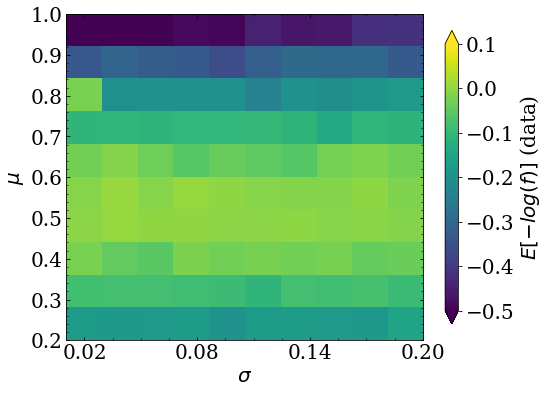

In [625]:
'''
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

im = plt.imshow(lossval1,origin='lower',extent=[0.01,0.2,0.2,1],aspect='auto',vmin=-0.5,vmax=0.1)
cbar = fig.colorbar(im, extend='both', spacing='proportional', shrink=0.9)
cbar.set_label('$E[-log(f)]$ (data)',fontsize=20)
cbar.ax.tick_params(labelsize=20) 
plt.xlabel(r"$\sigma$",fontsize=20)
plt.ylabel(r"$\mu$",fontsize=20)
plt.xticks(np.linspace(0.02,0.2,4))
'''

([<matplotlib.axis.XTick at 0x7fe88564c518>,
 <a list of 4 Text xticklabel objects>)

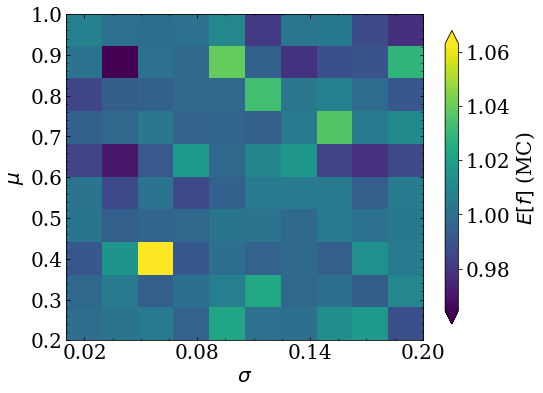

In [626]:
'''
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

im = plt.imshow(lossval2,origin='lower',extent=[0.01,0.2,0.2,1],aspect='auto')
cbar = fig.colorbar(im, extend='both', spacing='proportional', shrink=0.9)
cbar.set_label('$E[f]$ (MC)',fontsize=20)
cbar.ax.tick_params(labelsize=20) 
plt.xlabel(r"$\sigma$",fontsize=20)
plt.ylabel(r"$\mu$",fontsize=20)
plt.xticks(np.linspace(0.02,0.2,4))
'''